# Quantum error mitigation by layerwise Richardson extrapolation

This notebook can be used to reproduce all the results presented in the paper "Quantum error mitigation by layerwise Richardson extrapolation", [arXiv:2402.04000](https://arxiv.org/abs/2402.04000) (2024).

## Table of Contents

1. [Multivariate Lagrange interpolation](#multivariate_lagrange_interpolation)
2. [Layerwise Richardson extrapolation (LRE)](#layerwise_richardson_extrapolation)
    * [Noise scaling for LRE](#noise_scaling_for_lre)
    * [Chunkwise folding](#chunkwise_folding)
    * [Extrapolation for LRE](#extrapolation_for_lre)
    * [Executor functions for Mitiq](#executor_functions_for_mitiq)
    * [Compute sampling overheads](#compute_sampling_overheads)
3. [Experimental setting for LRE](#experimental_setting_for_lre)
    * [Noise model](#noise_model)
    * [Experimental setting for LRE](#experimental_setting_for_lre)
4. [Plotting](#plotting)
    * [Vary over number of layers](#vary_over_number_of_layers)
    * [Vary over extrapolation order](#vary_over_extrapolation_order)
    * [Vary over number of shots](#vary_over_number_of_shots)
    * [Vary over the gap between scale factors](#vary_over_the_gap_between_scale_factors)
    * [Vary over the number of circuit chunks](#vary_over_the_number_of_circuit_chunks)
    * [Benchmarking LRE with randomized circuits](#benchmarking_lre_with_randomized_circuits)
    
5. [Miscellaneous tools](#miscellaneous_tools)

### Imports and notebook presets

In [2]:
# Standard library imports.
import itertools
import os
import pickle
import random
from collections import Counter, defaultdict
from copy import deepcopy
from typing import Any, Callable, Generator, Optional

# Third-party library imports for scientific computing and data handling.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Quantum computing framework imports.
import cirq
import qiskit
from qiskit import AerSimulator, extensions
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.providers import Backend
import qiskit.providers.aer.noise as noise
from qiskit_aer.noise import NoiseModel

# Mitiq for quantum error mitigation.
import mitiq
from mitiq import zne
from mitiq.benchmarks import ghz_circuits
from mitiq.interface import accept_qprogram_and_validate
from mitiq.utils import _append_measurements, _pop_measurements
from mitiq.zne.scaling import fold_gates_at_random

# Functional programming utilities.
import functools

In [3]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 15
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 12

## Multivariate Lagrange interpolation
<a id="multivariate_lagrange_interpolation"></a>

This section introduces the mathematical machinery needed for interpolation (and later applied to layerwise folding). The approach of performing multivariate interpolation as described in this section is defined in ["A Simple Expression for Multivariate Lagrange Interpolation"](http://evoq-eval.siam.org/Portals/0/Publications/SIURO/Vol1_Issue1/A_Simple_Expression_for_Multivariate.pdf?ver=2018-03-30-130233-050).

### Computing monomials

We want to compute the set of mulitvariate monomials based on the number of variables represented by $n$ and the degree represented by $d$.

In [89]:
def get_monomials(n: int, d: int) -> list[str]:
    """Compute monomials of degree `d` in graded lexicographical order."""
    variables = [f"λ_{i}" for i in range(1, n + 1)]
    
    monomials = []
    for degree in range(d, -1, -1):
        # Generate combinations for the current degree
        combos = list(itertools.combinations_with_replacement(variables, degree))
        
        # Sort combinations lexicographically
        combos.sort()
        
        # Construct monomials from sorted combinations
        for combo in combos:
            monomial_parts = []
            counts = Counter(combo)
            # Ensure variables are processed in lexicographical order
            for var in sorted(counts.keys()):
                count = counts[var]
                if count > 1:
                    monomial_parts.append(f"{var}**{count}")
                else:
                    monomial_parts.append(var)
            monomial = "*".join(monomial_parts)
            # Handle the case where degree is 0
            if not monomial:
                monomial = "1"
            monomials.append(monomial)
    # "1" should be the first monomial. Note that order d > c > b > a means vector of monomials = [a, b, c, d].            
    return monomials[::-1]

For a vector of scale factors $\boldsymbol{\lambda} = (\lambda_1, \ldots, \lambda_{\ell})$, we define the basis of all monomial terms of $\ell$ variables of maximum degree $d$ as $\mathcal{M}(\boldsymbol{\lambda}, d)$. For instance, for $\boldsymbol{\lambda}(\lambda_1, \lambda_2)$ and $d = 2$, we have

$$
\mathcal{M}(\boldsymbol{\lambda}, 2) = \{1, \lambda_2 \lambda_1 \lambda_2^2 \lambda_1 \lambda_2 \lambda_1^2\}.
$$

In [90]:
n, d = 2, 2
monomials = get_monomials(n, d)
monomials

['1', 'λ_2', 'λ_1', 'λ_2**2', 'λ_1*λ_2', 'λ_1**2']

In general, the number of monomial terms if given by $M \equiv |\mathcal{M}(\boldsymbol{\lambda}, d)| = \binom{d+\ell}{d}$. For the case of $d = \ell = 2$ that we saw above, this gives $\binom{4}{2} = 6$.

In [91]:
print(f"Number of monomials: {len(monomials)}")

Number of monomials: 6


### Computing the sample matrix

Consider a collection of $N$ different scale factor vectors as defined as

$$
\Lambda = \{\boldsymbol{\lambda}_1, \boldsymbol{\lambda}_2, \ldots, \boldsymbol{\lambda}_N\},
$$

where each $\boldsymbol{\lambda}_i$ is a vector of $\ell$ scale factors that specifies how the noise is scaled across different layers

$$
\boldsymbol{\lambda}_i = \left(\lambda_1^{(i)}, \lambda_2^{(i)}, \ldots, \lambda_{\ell}^{(i)}\right), \quad \lambda_k^{(i)} \geq i.
$$

From $\Lambda$, we define the *sample matrix*

$$
\mathbf{A}(\Lambda, d) = 
\begin{pmatrix}
    a_{1,1} & a_{1,2} & \cdots & a_{1,M} \\
    a_{2,1} & a_{2,2} & \cdots & a_{2,M} \\
    \vdots & \vdots & \ddots & \vdots \\
    a_{N,1} & a_{N,2} & \cdots & a_{N,M}
\end{pmatrix}
$$

where each entry is defined as 

$$
a_{i,j} = \mathcal{M}_j(\boldsymbol{\lambda}_i, d).
$$

In [66]:
def sample_matrix(sample_points: list[int], degree: int) -> np.ndarray:
    """Construct a matrix from monomials evaluated at sample points."""
    n = len(sample_points[0])  # Number of variables based on the first sample point
    monomials = get_monomials(n, degree)
    matrix = np.zeros((len(sample_points), len(monomials)))

    for i, point in enumerate(sample_points):
        for j, monomial in enumerate(monomials):
            var_mapping = {f"λ_{k+1}": point[k] for k in range(n)}
            matrix[i, j] = eval(monomial, {}, var_mapping)
    return matrix

### Examples

The following examples generate sample matrices for specific settings and are replicated from ["A Simple Expression for Multivariate Lagrange Interpolation"](http://evoq-eval.siam.org/Portals/0/Publications/SIURO/Vol1_Issue1/A_Simple_Expression_for_Multivariate.pdf?ver=2018-03-30-130233-050).

#### Example 1

In [67]:
n, d = 2, 1
sample_points = [(0, 0), (0, 1), (1, 1)]
monomials = get_monomials(n=2, d=1)
print(f"Monomials: {monomials}")

Monomials: ['λ_1', 'λ_2', '1']


In [68]:
mat = sample_matrix(sample_points=sample_points, degree=d)
mat

array([[0., 0., 1.],
       [0., 1., 1.],
       [1., 1., 1.]])

#### Example 2

In [69]:
n, d = 2, 2
sample_points = [(0, 1), (2, 1), (1, 3), (-2, -1), (-3, 2), (-1, 2)]
monomials = get_monomials(n, d)

print(f"Monomials: {monomials}")

Monomials: ['λ_1**2', 'λ_1*λ_2', 'λ_2**2', 'λ_1', 'λ_2', '1']


In [70]:
mat = sample_matrix(sample_points=sample_points, degree=d)
mat

array([[ 0.,  0.,  1.,  0.,  1.,  1.],
       [ 4.,  2.,  1.,  2.,  1.,  1.],
       [ 1.,  3.,  9.,  1.,  3.,  1.],
       [ 4.,  2.,  1., -2., -1.,  1.],
       [ 9., -6.,  4., -3.,  2.,  1.],
       [ 1., -2.,  4., -1.,  2.,  1.]])

## Layerwise Richardson extrapolation (LRE)
<a id="layerwise_richardson_extrapolation"></a>

Functionality for the LRE error mitigation protocol in which the noise of different individual layers (or larger chunks of the circuit) is amplified and the associated expectation values are linearly combined to estimate the zero-noise limit. Refer to the [arXiv:2402.04000](https://arxiv.org/abs/2402.04000) posting for more details on the LRE technique.

### General-purpose utilities

In [71]:
def split(a: np.ndarray, n: int) -> Generator:
    """Split list or numpy array into `n` (approximately) equal lengths.    

    Adapted from:
    https://stackoverflow.com/questions/2130016/splitting-a-list-into-n-parts-of-approximately-equal-length
    """
    if n > len(a):
        raise ValueError("Number of chunks cannot exceed the length of the array.")    
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m) : (i+1) * k + min(i + 1, m)] for i in range(n))

### Circuit utilities

In [72]:
def random_circuit(depth: int, num_qubits: int, cnot_weight: float = 0.9) -> qiskit.QuantumCircuit:
    """Generate a random circuit from  single-qubit gates (H, X, Y, Z, S, T) and CNOT gates.
    
    Args:
        depth: The depth of the circuit to generate.
        num_qubits: The width (number of qubits) for the circuit to generate.
        cnot_weight: A probabilistic weighting for the randomly selected gate to be a CNOT gate.
        
    Returns:
        A randomly generated quantum circuit with a probabilistically weighted number of CNOT gates.
    """
    # Create a new quantum circuit
    qc = qiskit.QuantumCircuit(num_qubits)

    # Define the single-qubit gates (excluding identity)
    single_qubit_gates = [qiskit.circuit.library.XGate(),
                          qiskit.circuit.library.YGate(),
                          qiskit.circuit.library.ZGate(),
                          qiskit.circuit.library.HGate(),
                          qiskit.circuit.library.TGate(),
                          qiskit.circuit.library.SGate()]

    for _ in range(depth):
        used_qubits = set()
        for qubit in range(num_qubits):
            if qubit not in used_qubits:
                # With probability cnot_weight, add a CNOT gate if there are at least 2 qubits left.
                if random.random() < cnot_weight and num_qubits - len(used_qubits) > 1:
                    # Choose a target qubit different from the control qubit for the CNOT gate.
                    available_qubits = [qb for qb in range(num_qubits) if qb not in used_qubits and qb != qubit]
                    target_qubit = random.choice(available_qubits)
                    qc.cx(qubit, target_qubit)
                    used_qubits.add(qubit)
                    used_qubits.add(target_qubit)
                else:
                    # Otherwise, add a random single-qubit gate
                    gate = random.choice(single_qubit_gates)
                    qc.append(gate, [qubit])
                    used_qubits.add(qubit)

    return qc

### Noise scaling for LRE
<a id="noise_scaling_for_lre"></a>

An $n$-qubit circuit $C$ may be represented as a series of $\ell$ layers. Each layer $L_k$ for $1 \leq k \leq \ell$ contains one of more quantum gates acting concurrently on an $n$-qubit system

$$
C = L_{\ell} L_{\ell - 1} \cdots L_2 L_1.
$$

In [73]:
def get_num_layers_without_measurements(circuit: qiskit.QuantumCircuit) -> int:
    """Number of layers for a circuit (without measurements)."""    
    new_circ = qiskit.QuantumCircuit(*circuit.qregs)

    # Ignore barrier and measure constructs in circuit.
    for instr, qargs, cargs in circuit.data:
        if instr.name != "measure" and instr.name != "barrier":
            new_circ.append(instr, qargs, cargs)

    dag = circuit_to_dag(new_circ)
    return len([dag_to_circuit(layer["graph"]) for layer in dag.layers()])

For a collection of scale factor vectors defined by $\Lambda$, we denote

$$
C^{\Lambda} = \{C^{\boldsymbol{\lambda}}_1, C^{\boldsymbol{\lambda}}_2, \ldots, C^{\boldsymbol{\lambda}_N}\}
$$

as the corresponding set of circuits. Each circuit in $C^{\Lambda}$ is layerwise noise-scaled according to the corresponding scale factor vector. For layerwise folding, each scale factor $\lambda_k^{(i)}$ corresponds to the $k$-th layer $L_k$ of the circuit $C$ and is defined as

$$
\lambda_k^{(i)} = 1 + 2 m_k^{(i)}.
$$

Here, $m_k^{(i)}$ is a non-negative integer representing the number of times the $k$-th layer $L_k$ is to be folded. The folding operation for each layer is expressed as

$$
L_k^{\lambda_k^{(i)}} = \left(L_k L_k^{\dagger}\right)^{m_k^{(i)}} L_k,
$$

where $L_k^{\lambda_k^{(i)}}$ is the new $k$-th layer after the folding operation. For a given vector $\boldsymbol{\lambda}_i$ of scale factors, the resulting circuit $C^{\boldsymbol{\lambda}_i}$ is represented as

$$
C^{\boldsymbol{\lambda}_i} = L_1^{\lambda_1^{(i)}} L_2^{\lambda_2^{(i)}} \cdots L_{\ell - 1}^{\lambda_{\ell - 1}^{(i)}} L_{\ell}^{\lambda_{\ell}^{(i)}}.
$$

In [74]:
def compute_folding_patterns(num_layers: int, degree: int, fold_multiplier: int) -> list[tuple[int]]:
    """Computes all folding patterns of a specified degree and scaled by fold_multiplier."""    
    result = []
    for i in range(degree + 1):
        for j in itertools.combinations_with_replacement(range(num_layers), i):
            pattern = [0] * num_layers
            for index in j:
                pattern[index] += 1
            result.append(tuple(fold_multiplier * np.array(pattern)))
    return result

In [75]:
def generate_scale_factors(num_layers: int, degree: int, fold_multiplier: int) -> list[int]:
    """Compute the corresponding scale factors from the folding patterns of the circuit."""
    patterns = compute_folding_patterns(num_layers=num_layers, degree=degree, fold_multiplier=fold_multiplier)
    return [
        tuple(2 * num_folds + 1 for num_folds in pattern)
        for pattern in patterns
    ]

### Chunkwise folding
<a id="chunkwise_folding"></a>

If instead of decomposing the circuit into a sequence of elementary layers (of depth one) we split the circuit into chunks of arbitrary depth, the whole theory of LRE is equally applicable. Refer to Section C. Applying LRE to chunks of the circuit in the preprint [arXiv:2402.04000](https://arxiv.org/abs/2402.04000) for more details.

In [76]:
@accept_qprogram_and_validate
def chunkwise_noise_scaling(
    circuit: cirq.Circuit,
    scale_factors: list[float],
    chunk_scaling_function: Callable[[cirq.Circuit, float], cirq.Circuit] = fold_gates_at_random,
) -> cirq.Circuit:
    """Applies a noise scaling function to select chunks of the circuit based on a list of scale factors.

    Args:
        circuit: The input quantum circuit (cirq.Circuit) to be processed.
        scale_factors: A list of scale factors (list of floats), each associated with
                       a corresponding chunk of the circuit. These factors determine
                       the extent to which each chunk is modified by the noise scaling
                       function. Odd integers are recommended for scale factors, 
                       especially for small chunks.
        chunk_scaling_function: A callable that takes a quantum circuit and a float
                                (scale factor) and returns a quantum circuit. This
                                function is applied to each chunk of the circuit based
                                on the corresponding scale factor. Default is 
                                'fold_gates_at_random', which applies random gate folding.

    Returns:
        cirq.Circuit: The resulting circuit after applying the noise scaling function
                      to each chunk as dictated by the scale factors.        
    """
    # Remove terminal measurements and store them.
    folded = deepcopy(circuit)
    measurements = _pop_measurements(folded)

    # Apply folding to each chunk according to the corresponding scale factor.
    folded_circuit = cirq.Circuit()
    chunks = split(folded, len(scale_factors))
    for chunk, scale_factor in zip(chunks, scale_factors):
        # Only apply folding if scale factor is greater than 1.
        if scale_factor > 1:
            combined_circuit_chunk = cirq.Circuit(chunk)
            folded_chunk = chunk_scaling_function(combined_circuit_chunk, scale_factor=scale_factor)
            folded_circuit += folded_chunk
        else:
            folded_circuit += chunk

    # Re-append the measurements.
    _append_measurements(folded_circuit, measurements)

    return folded_circuit

### Extrapolation for LRE
<a id="extrapolation_for_lre"></a>

This function is useful to be able to extract the terms used for the linear equation solving procedure of LRE.

In [77]:
def get_eta_coeffs_from_sample_matrix(mat: np.ndarray) -> list[float]:
    """Given a sample matrix compute the eta coefficients."""
    n_rows, n_cols = mat.shape
    if n_rows != n_cols:
        raise ValueError("The matrix must be square.")

    det_m = np.linalg.det(mat)    
    if det_m == 0:
        raise ValueError("The matrix is singular.")
    
    terms = []
    for i in range(n_rows):
        new_mat = mat.copy()
        new_mat[i] = np.array([[0] * (n_cols - 1) + [1]])        
        terms.append(np.linalg.det(new_mat) / det_m)

    return terms

In [78]:
def get_eta_coeffs(lre_scale_factors: list[float], degree: int) -> list[float]:
    """Obtain eta coefficients from list of scale factors and degree."""
    mat = sample_matrix(sample_points=lre_scale_factors, degree=degree)
    return get_eta_coeffs_from_sample_matrix(mat) 

For single-variable Richardson extrapolation, one can also get the eta coefficients from the standard single-variable Lagrange interpolation polynomial.

In [79]:
def get_eta_coeffs_single_variable(scale_factors: list[float]) -> list[float]:
    """Returns the array of single-variable Richardson extrapolation coefficients associated
    to the input array of scale factors."""
    # Lagrange interpolation formula.
    richardson_coeffs = []
    for l in scale_factors:
        coeff = 1.0
        for l_prime in scale_factors:
            if l_prime == l:
                continue
            coeff *= l_prime / (l_prime - l)
        richardson_coeffs.append(coeff)

    return richardson_coeffs

Layerwise Richardson extrapolation reduces to standard single-variable Richardson extrapolation when the number of layers (or number of circuit chunks) is equal to 1. So we can run the following consistency check:

In [80]:
# Test LRE = RE for num_layers=1.
re_scale_factors = [1 + num_folds * 2 for num_folds in range(5)]
lre_scale_factors = [(s, ) for s in re_scale_factors] # Tuples with single element since num_layers=1

assert lre_scale_factors == generate_scale_factors(num_layers=1, degree=4, fold_multiplier=1)
assert np.allclose(get_eta_coeffs_single_variable(re_scale_factors), get_eta_coeffs(lre_scale_factors, degree=4))

Given the list of eta coefficients, one can easily compute the sampling overhead of LRE. The following function returns the optimal overhead (valid when optimizing the shots per circuit) and the sub-optimal overhead (valid when using the same shots per circuit). See LRE paper for more details.

### Executor functions for Mitiq
<a id="executor_functions_for_mitiq"></a>

In [81]:
def execute(
    circuit: qiskit.QuantumCircuit, 
    backend: Backend, 
    shots: float, 
    noise_model = None
) -> float:
    """Executor for a Qiskit circuit."""
    print(f"Executing circuit with shots = {shots}")
    
    circuit_with_measurement = circuit.copy()
    circuit_with_measurement.measure_all()
    
    if noise_model:
        job = qiskit.execute(
            experiments=circuit_with_measurement,
            backend=backend,
            noise_model=noise_model,
            basis_gates=noise_model.basis_gates if noise_model is not None else None,
            optimization_level=0,  # Important to preserve folded gates.
            shots=shots,
        )
    # Can set a backend without specifying noise model explicitly.
    else:
        print(f"Executing backend {backend.name}")
        job = backend.run(
            circuit_with_measurement,
            optimization_level=0,  # Important to preserve folded gates.
            shots=shots
        )

    # Convert from raw measurement counts to the expectation value.
    counts = job.result().get_counts()

    key = "0" * len(circuit.qubits)
    expectation_value = 0.0 if counts.get(key) is None else counts.get(key) / shots
    return expectation_value

In [82]:
def execute_no_shot_noise(circuit: qiskit.QuantumCircuit, noise_model: Optional[NoiseModel] = None) -> float:
    """Executor that uses density matrix simulator to reduce all shot noise.
    
    Adapted from the `execute_with_noise` function from mitiq.
    https://github.com/unitaryfund/mitiq/blob/ee85edf48557c85c4f6d0b1e1d74d74fc882c9d4/mitiq/interface/mitiq_qiskit/qiskit_utils.py#L85
    """
    circ = circuit.copy()
    circ.save_density_matrix()

    basis_gates = None if noise_model is None else noise_model.basis_gates + ["save_density_matrix"]

    # execution of the experiment
    job = qiskit.execute(
        circ,
        backend=AerSimulator(method="density_matrix", noise_model=noise_model),
        basis_gates=basis_gates,
        optimization_level=0,
        shots=1,
    )
    rho = np.asarray(job.result().data()["density_matrix"])
    return float(rho[0, 0].real)

In [83]:
def execute_with_lre(
    circuit: qiskit.QuantumCircuit, 
    executor,
    shots: int,
    degree: int,
    fold_multiplier: int,
    optimize_shots: bool,
    num_chunks: Optional[int] = None,    
):
    # Classical pre-processing
    if num_chunks is None:
        num_layers = get_num_layers_without_measurements(circuit)
        print(f"Number of layers (w/o measurements): {num_layers}")
    else:
        num_layers = num_chunks

    lre_scale_factors = generate_scale_factors(
        num_layers=num_layers, degree=degree, fold_multiplier=fold_multiplier
    )
     
    print("Start computing eta coeffs.")
    eta_coeffs = get_eta_coeffs(lre_scale_factors, degree)
    print("End computing eta coeffs.")

    print("Start layerwise folding.")
    folded_circuits = [chunkwise_noise_scaling(circuit, scale_factors) for scale_factors in lre_scale_factors]
    print("End layerwise folding.")
    print(f"Number of folded circuits {len(folded_circuits)}")    
    
    if optimize_shots:
        shots_factors = np.abs(np.array(eta_coeffs))
        rescaled_shots = list(map(int, np.floor(shots * shots_factors / np.sum(shots_factors))))
    else:
        normalized_shots = shots // len(eta_coeffs) 
        rescaled_shots = [normalized_shots] * len(eta_coeffs)   
    
    lre_noisy_values = []
    # Computes noisy values for every folding pattern.
    print("Start running circuits.")
    for scale_factors, circuit_shots, folded_circuit in zip(lre_scale_factors, rescaled_shots, folded_circuits):
        noisy_val = executor(folded_circuit, shots=circuit_shots)

        # Scale factors are defined by the following function of the folding pattern tuple.
        lre_noisy_values.append(noisy_val)
        print(f"Noise scaled value with scale factors {scale_factors} is: {noisy_val}")
    print("End running circuits.")
    
    return np.dot(lre_noisy_values, eta_coeffs)

### Compute sampling overheads
<a id="compute_sampling_overheads"></a>

Before running any quantum computation we can estimate the sampling overhead required by LRE. The next plots show how the overhead depends on the number of layers and on the gap between scale factors.

In [84]:
def compute_overheads(num_layers: int, degree: int, fold_multiplier: int) -> tuple[float, float]:
    """Compute sampling overhead of LRE."""
    scale_factors_list = generate_scale_factors(num_layers, degree, fold_multiplier=fold_multiplier)
    mat = sample_matrix(scale_factors_list, degree)
    
    coeffs = get_eta_coeffs_from_sample_matrix(mat)
    
    one_norm = np.linalg.norm(coeffs)
    two_norm = np.linalg.norm(coeffs, 2)
    
    overhead = one_norm ** 2
    overhead_tilde = len(coeffs) * two_norm ** 2
    
    return overhead, overhead_tilde

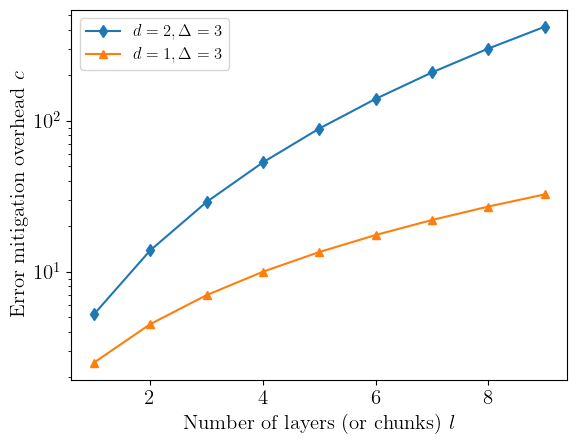

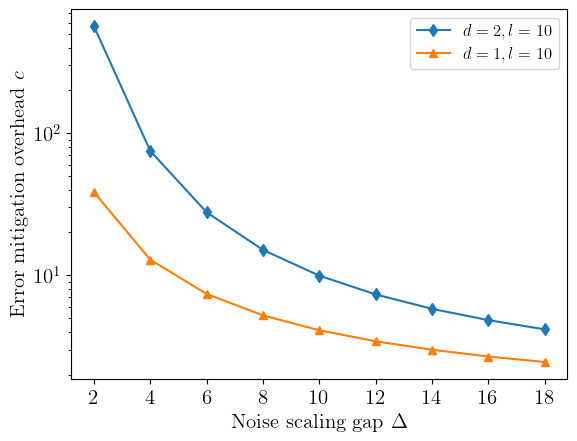

In [85]:
# Plot overheads vs depth
depths = range(1, 10)
overheads = []
overheads_tilde = []
overheads_lin = []
overheads_tilde_lin = []
for depth in depths:
    cost_lin, cost_tilde_lin = compute_overheads(num_layers=depth, degree=1, fold_multiplier=1)
    cost, cost_tilde = compute_overheads(num_layers=depth, degree=2, fold_multiplier=1)
    overheads.append(cost)
    overheads_tilde.append(cost_tilde) 
    overheads_lin.append(cost_lin)
    overheads_tilde_lin.append(cost_tilde_lin) 
    
plt.plot(depths, overheads,"-d", label="$d=2, \Delta=3$", color="#1f77b4")
# plt.plot(depths, overheads_tilde, "-s", label="$\\tilde{c}\, ({\\rm quadratic})$", color="#1f77b4")
plt.plot(depths, overheads_lin,"-^", label="$d=1,  \Delta=3$", color="#ff7f0e")
# plt.plot(depths, overheads_tilde_lin, "-v", label="$\\tilde{c}\, ({\\rm linear})$", color="#ff7f0e")
plt.yscale('log')

plt.xlabel("Number of layers (or chunks) $l$ ")
plt.ylabel("Error mitigation overhead $c$")
#plt.xticks(depths)    

plt.legend()

save_fig = True
if save_fig:
    output_file_name = "overhead"
    plt.savefig(os.path.join("plots", f"{output_file_name}.pdf"))  
plt.show()
              
# Plot overheads vs multiplier
depth = 10
overheads = []
overheads_tilde = []
overheads_lin = []
overheads_tilde_lin = []
multipliers = range(1, 10)
for multiplier in multipliers:
    cost_lin, cost_tilde_lin = compute_overheads(num_layers=depth, degree=1, fold_multiplier=multiplier)
    cost, cost_tilde = compute_overheads(num_layers=depth, degree=2, fold_multiplier=multiplier)
    overheads.append(cost)
    overheads_tilde.append(cost_tilde) 
    overheads_lin.append(cost_lin)
    overheads_tilde_lin.append(cost_tilde_lin) 

noise_scaling_gaps = [2 * m for m in multipliers]
plt.plot(noise_scaling_gaps, overheads,"-d", label="$d=2, l=10$", color="#1f77b4")
# plt.plot(noise_scaling_gaps, overheads_tilde, "-s", label="$\\tilde{c}\, ({\\rm quadratic})$", color="#1f77b4")
plt.plot(noise_scaling_gaps, overheads_lin,"-^", label="$d=1, l=10$", color="#ff7f0e")
# plt.plot(noise_scaling_gaps, overheads_tilde_lin, "-v", label="$\\tilde{c}\, ({\\rm linear})$", color="#ff7f0e")
plt.yscale("log")

plt.xlabel("Noise scaling gap $\Delta$")
plt.ylabel("Error mitigation overhead $c$")
plt.xticks(noise_scaling_gaps)    

plt.legend()

save_fig = True
if save_fig:
    output_file_name = "overhead_vs_lambdamin"
    plt.savefig(os.path.join("plots", f"{output_file_name}.pdf"))  

## Experimental setting for LRE
<a id="experimental_setting_for_lre"></a>

### Noise model
<a id="noise_model"></a>

We consider an amplitude damping channel defined via the Qiskit Aer simulator for our experiments. The single-qubit amplitude damping channel is represented as

$$
\mathcal{E}_1(\rho) = E_0 \rho E_0^{\dagger} + E_1 \rho_1 E_1^{\dagger}
$$

where,

$$
E_0 = 
\begin{bmatrix}
    1 & 0 \\ 0 & \sqrt{1 - p_1}
\end{bmatrix}
\quad \text{and} \quad
E_1 = 
\begin{bmatrix}
    0 & \sqrt{p_1} \\ 0 & 0
\end{bmatrix}.
$$

This channel is added to all single-qubit gates. For the two-qubit CNOT gate, we apply the tensor product of two single-qubit channels,

$$
\mathcal{E}_2(\rho) = \sum_{i \in \{0,1\}} \sum_{j \in \{0,1\}} E_i \otimes E_j \rho E_i^{\dagger} \otimes E_j^{\dagger}.
$$
Unless otherwise specified, we define $p_1 = 0.04$ and $p_2 = 0.08$.

In [86]:
def amplitude_damping_noise_model(prob_1: float = 0.04, prob_2: float = 0.08) -> NoiseModel:
    """Defines an amplitude damping noise model with one-qubit and two-qubit errors.
    
    Args:
        prob_1: One-qubit gate error rate (default 4%).
        prob_2: Two-qubit gate error rate (default 8%).
    Returns:
        Amplitude damping noise model.
    """
    # Quantum errors
    error_1 = noise.amplitude_damping_error(param_amp=prob_1, excited_state_population=1)

    error_2 = noise.amplitude_damping_error(param_amp=prob_2, excited_state_population=1)
    error_2 = error_2.tensor(error_2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ["u1", "u2", "u3"])
    noise_model.add_all_qubit_quantum_error(error_2, ["cx"])
    
    return noise_model

### LRE experiment workflow
<a id="lre_experiment_workflow"></a>

The following function allows one to specify a given quantum circuit to run as well as a backend and noise model to run against. Hyperparameters may also be specified here (i.e. number shots, degree of the polynomial, number of chunks, etc.). The function captures the expectation values for LRE, RE, and unimitigated runs of the circuit and returns the values in a dictionary data structure. These values can be (as they are done later in this notebook) plotted for comparison and analysis.

In [87]:
def run_experiment(
    circuit: qiskit.QuantumCircuit, 
    backend: Backend, 
    noise_model: NoiseModel, 
    shots: int,
    degree: int,
    fold_multiplier: int,
    optimize_shots: bool,
    num_chunks: Optional[int] = None,
    num_trials: int = 1
) -> dict[str, float]:
    """Calculate ideal, unmitigated, ZNE, and LRE values/data."""
    print(circuit)
    
    results = defaultdict(dict)
    for trial in range(num_trials):
        print("********************************************")
        print(f"Trial number {trial}")
        print("********************************************")
        # Ideal (noiseless) expectation value:
        ideal_val = np.around(execute_no_shot_noise(circuit), decimals=1)
        print(f"Ideal value: {ideal_val}\n")

        # Unmitigated expectation value:
        unmit_val = execute(
            circuit=circuit, backend=backend, shots=shots, noise_model=noise_model
        )
        unmit_error = abs(ideal_val - unmit_val)
        print(f"Unmitigated expectation value: {unmit_val}")
        print(f"Unmitigated estimation error: {unmit_error}\n")

        zne_executor = functools.partial(execute, backend=backend, noise_model=noise_model)

        # ZNE:
        zne_val = execute_with_lre(
            circuit=circuit, 
            executor=zne_executor,
            shots=shots, 
            degree=degree, 
            fold_multiplier=fold_multiplier,
            optimize_shots=optimize_shots,
            num_chunks=1,
        )
        zne_error = abs(ideal_val - zne_val)
        print(f"ZNE expectation value: {zne_val}")
        print(f"ZNE estimation error: {zne_error}\n")    

        # LRE:
        lre_val = execute_with_lre(
            circuit=circuit, 
            executor=zne_executor,
            shots=shots, 
            degree=degree, 
            fold_multiplier=fold_multiplier,
            optimize_shots=optimize_shots,
            num_chunks=num_chunks,        
        )
        lre_error = abs(ideal_val - lre_val)    
        print(f"Layerwise ZNE expectation value: {lre_val}")
        print(f"Layerwise ZNE estimation error: {lre_error}\n")    

        percent_improvement = ((zne_error - lre_error) / lre_error) * 100
        print(f"Layerwise error-rate improvement over ZNE: {percent_improvement:.2f}%")
        results[trial] = {
            "ideal_val": ideal_val,
            "unmit_val": unmit_val,
            "zne_val": zne_val,
            "lre_val": lre_val,        
        }
    return results

### Example: 4-qubit GHZ-like circuit (degree 2) with chunk-size 3

In [88]:
# GHZ-like circuit.
ghz_circuit = generate_ghz_circuit(4, "qiskit")
circuit = ghz_circuit.compose(ghz_circuit.inverse())

run_experiment(
    circuit=circuit, 
    shots=10**6,
    backend=qiskit.Aer.get_backend("aer_simulator"), 
    noise_model=amplitude_damping_noise_model(), 
    degree=2,
    fold_multiplier=1,
    optimize_shots = True,
    num_chunks=3,
)

     ┌───┐                              ┌───┐
q_0: ┤ H ├──■────────────────────────■──┤ H ├
     └───┘┌─┴─┐                    ┌─┴─┐└───┘
q_1: ─────┤ X ├──■──────────────■──┤ X ├─────
          └───┘┌─┴─┐          ┌─┴─┐└───┘     
q_2: ──────────┤ X ├──■────■──┤ X ├──────────
               └───┘┌─┴─┐┌─┴─┐└───┘          
q_3: ───────────────┤ X ├┤ X ├───────────────
                    └───┘└───┘               
********************************************
Trial number 0
********************************************
Ideal value: 1.0

Executing circuit with shots = 1000000
Unmitigated expectation value: 0.539863
Unmitigated estimation error: 0.460137

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 3
Start running circuits.
Executing circuit with shots = 535714
Noise scaled value with scale factors (1,) is: 0.5403573548572559
Executing circuit with shots = 357142
Noise scaled value with scale factors (3,) is: 0

defaultdict(dict,
            {0: {'ideal_val': 1.0,
              'unmit_val': 0.539863,
              'zne_val': 0.7894777792113341,
              'lre_val': 0.888571593569069}})

## Plotting

The remaining sections of this notebook may be used to reproduce the plots in the paper.

In [32]:
def plot_experiment_expectation_values(
    results_list: list[dict], 
    output_file_name: str, 
    x_axis_key: str,
    x_axis_label: str,
    x_ticks_labels: Optional[list[str]] = None,
    show_error_bars: bool = False,
    is_log_scale: bool = False,
    is_zne_static: bool = False,
    is_unmit_static: bool = False,
    save: bool = True
):
    # Initialize data structures for aggregation.
    aggregated_data = {"ideal_val": {}, "unmit_val": {}, "zne_val": {}, "lre_val": {}}

    # Iterate over each dictionary (each number of qubits)
    for result in results_list:
        x_value = result[x_axis_key]
        num_trials = result["num_trials"]

        for trial in range(num_trials):
            trial_data = result[trial]
            for key in aggregated_data.keys():
                aggregated_data[key].setdefault(x_value, []).append(trial_data[key])

    # Compute means and standard deviations
    means, stds = {}, {}
    for key in aggregated_data.keys():
        means[key] = [np.mean(aggregated_data[key][x_value]) for x_value in sorted(aggregated_data[key])]
        if show_error_bars:
            stds[key] = [np.std(aggregated_data[key][x_value]) for x_value in sorted(aggregated_data[key])]

    # Plotting
    x_values_list = sorted(list(aggregated_data["ideal_val"].keys()))
    
    # Set custom x-axis tick labels if provided, else use default x_values_list
    if x_ticks_labels is None:
        x_ticks_labels = x_values_list
        
    plt.axhline(y=np.mean(means["ideal_val"]), color="tab:red", linestyle="--", label="Ideal value")

    # Plot each value with error bars or static lines based on flags
    plt.errorbar(x_values_list, means["lre_val"], yerr=stds.get("lre_val") 
                 if show_error_bars else None, label="LRE", marker="^", color="tab:green",
                 elinewidth=2, capsize=5, capthick=2)

    if is_unmit_static:
        plt.axhline(y=means["unmit_val"][0], color="tab:blue", label="Unmitigated", linewidth=2)
    else:
        plt.errorbar(x_values_list, means["unmit_val"], yerr=stds.get("unmit_val") 
                     if show_error_bars else None, label="Unmitigated", marker="o", color="tab:blue",
                     elinewidth=2, capsize=5, capthick=2)

    if is_zne_static:
        plt.axhline(y=means["zne_val"][0], color="tab:orange", label="RE", linewidth=2)
    else:
        plt.errorbar(x_values_list, means["zne_val"], yerr=stds.get("zne_val") 
                     if show_error_bars else None, label="RE", marker="s", color="tab:orange",
                     elinewidth=2, capsize=5, capthick=2)
    
    plt.xlabel(x_axis_label)
    plt.ylabel("Expectation value")
    plt.xticks(x_values_list, x_ticks_labels)

    if is_log_scale:
        plt.xscale("log") 
    plt.legend()

    if save:
        plt.savefig(os.path.join("plots", f"{output_file_name}.pdf"))    

        with open(os.path.join("data", f"{output_file_name}.pickle"), "wb") as handle:    
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    plt.show()

### Plot: Vary over number of layers
<a id="vary_over_number_of_layers"></a>

In [33]:
def range_over_qubits(
    circuits: list[qiskit.QuantumCircuit],
    optimize_shots: bool,
    num_chunks: int,
    shots: float = 10**6,
    backend: Backend = qiskit.Aer.get_backend("aer_simulator"),
    noise_model: NoiseModel = amplitude_damping_noise_model(),
    degree: float = 2,
    fold_multiplier: int = 1,
    num_trials: int = 1
):
    return [
        {
            **run_experiment(
                circuit=circuit, 
                shots=shots,
                backend=backend, 
                noise_model=noise_model, 
                degree=degree,
                fold_multiplier=fold_multiplier,
                optimize_shots=optimize_shots,
                num_chunks=num_chunks,
                num_trials=num_trials,
            ),
            "circuit": circuit,
            "num_qubits": circuit.num_qubits,
            "shots": shots,
            "backend": backend,
            "noise_model": noise_model,
            "degree": degree,
            "fold_multiplier": fold_multiplier,
            "num_trials": num_trials
        }
        for circuit in circuits
    ]

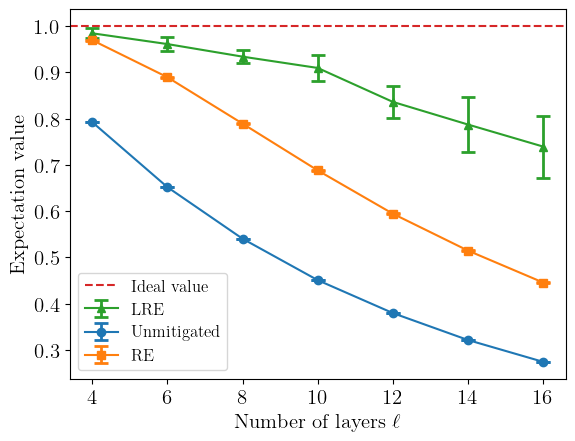

In [35]:
num_qubits = range(2, 9)
circuits = [
    generate_ghz_circuit(qubits, "qiskit").compose(generate_ghz_circuit(qubits, "qiskit").inverse())
    for qubits in num_qubits
]
results = range_over_qubits(circuits=circuits, optimize_shots=True, num_chunks=None, num_trials=10, shots=10**6)

plot_experiment_expectation_values(
    results_list=results, 
    x_axis_key="num_qubits",
    x_axis_label="Number of layers $\ell$",
    # Num layers = 2 * num qubits. the relevant parameter of LRE is “l” not “n”. E.g., 
    # error bars increase because “l” increases, not because “n” increases.
    x_ticks_labels = [x * 2 for x in num_qubits],
    save=True,
    show_error_bars=True,
    is_log_scale=False,
    output_file_name=f"ghz_num_qubits",
)

### Plot: Vary over number of shots
<a id="vary_over_number_of_shots"></a>

In [36]:
def range_over_shots_exponents(
    circuit: qiskit.QuantumCircuit,
    optimize_shots: bool,
    num_chunks: int,    
    shots_exponents: list[float],
    backend: Backend = qiskit.Aer.get_backend("aer_simulator"),
    noise_model: NoiseModel = amplitude_damping_noise_model(),
    degree: float = 2,
    fold_multiplier: int = 1,
    num_trials: int = 1
):
    return [
        {
            **run_experiment(
                circuit=circuit, 
                shots=10**shots_exponent,
                backend=backend, 
                noise_model=noise_model, 
                degree=degree,
                fold_multiplier=fold_multiplier,
                optimize_shots=optimize_shots,
                num_chunks=num_chunks,
                num_trials=num_trials,
            ),
            "circuit": circuit,
            "num_qubits": circuit.num_qubits,
            "shots": 10**shots_exponent,
            "backend": backend,
            "noise_model": noise_model,
            "degree": degree,
            "fold_multiplier": fold_multiplier,
            "num_trials": num_trials,
        }
        for shots_exponent in shots_exponents
    ]

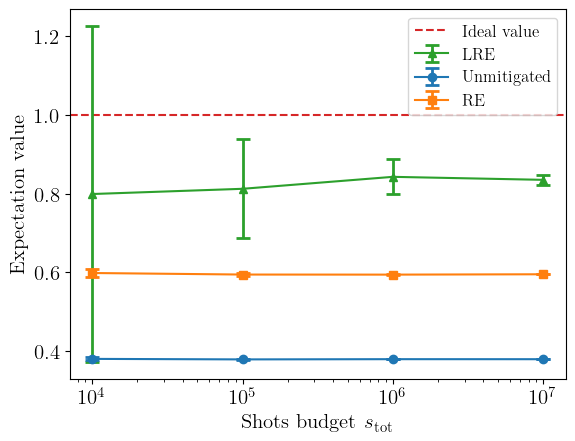

In [38]:
shots_exponents = range(4, 8)
circuit = generate_ghz_circuit(6, "qiskit").compose(generate_ghz_circuit(6, "qiskit").inverse())
results = range_over_shots_exponents(
    circuit=circuit, shots_exponents=shots_exponents, optimize_shots=True, num_chunks=None, num_trials=10,
)

plot_experiment_expectation_values(
    results_list=results,
    x_axis_key="shots",
    x_axis_label="Shots budget $s_{\\rm tot}$", 
    x_ticks_labels=[f"$10^{exp}$" for exp in shots_exponents],
    save=True,
    is_log_scale=True,
    show_error_bars=True,
    output_file_name=f"ghz_num_shots",
)

### Plot: Vary over the gap between scale factors
<a id="vary_over_the_gap_between_scale_factors"></a>

In [39]:
def range_over_fold_multiplier(
    circuit: qiskit.QuantumCircuit,
    optimize_shots: bool,    
    num_chunks: int,
    fold_multipliers: list[int],    
    shots: float = 10**6,
    backend: Backend = qiskit.Aer.get_backend("aer_simulator"),
    noise_model: NoiseModel = amplitude_damping_noise_model(),
    degree: float = 2,
    num_trials: int = 1,
):
    return [
        {
            **run_experiment(
                circuit=circuit, 
                shots=shots,
                backend=backend, 
                noise_model=noise_model, 
                degree=degree,
                fold_multiplier=fold_multiplier,
                optimize_shots=optimize_shots,
                num_chunks=num_chunks,
                num_trials=num_trials,
            ),
            "circuit": circuit,
            "num_qubits": circuit.num_qubits,            
            "shots": shots,
            "backend": backend,
            "noise_model": noise_model,
            "degree": degree,
            "fold_multiplier": fold_multiplier,
            "num_trials": num_trials,
        }
        for fold_multiplier in fold_multipliers
    ]

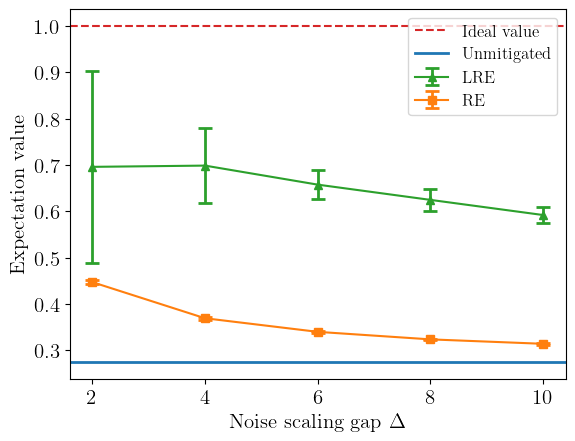

In [40]:
fold_multipliers=range(1, 6)
circuit = generate_ghz_circuit(8, "qiskit").compose(generate_ghz_circuit(8, "qiskit").inverse())

results = range_over_fold_multiplier(
    circuit=circuit,
    fold_multipliers=fold_multipliers, 
    optimize_shots=True, 
    num_chunks=None,
    shots=10**5,
    num_trials=10,
)

plot_experiment_expectation_values(
    results_list=results, 
    x_axis_key="fold_multiplier",
    x_axis_label="Noise scaling gap $\Delta$",
    # Requires rescaling x values such that the first point is at lambda_min=3 instead of 1.
    x_ticks_labels=[multiplier * 2 for multiplier in fold_multipliers],
    save=True,
    is_log_scale=False,
    is_unmit_static=True,
    show_error_bars=True,
    output_file_name=f"ghz_fold_multiplier",
)

### Plot: Vary over extrapolation order
<a id="vary_over_extrapolation_order"></a>

In [41]:
def range_over_degree(
    circuit: qiskit.QuantumCircuit,
    optimize_shots: bool,
    num_chunks: int,
    degrees: list[int],
    shots: float = 10**6,
    backend: Backend = qiskit.Aer.get_backend("aer_simulator"),
    noise_model: NoiseModel = amplitude_damping_noise_model(),
    fold_multiplier: int = 1,
    num_trials: int = 1
):
    return [
        {
            **run_experiment(
                circuit=circuit, 
                shots=shots,
                backend=backend, 
                noise_model=noise_model, 
                degree=degree,
                fold_multiplier=fold_multiplier,
                optimize_shots=optimize_shots,
                num_chunks=num_chunks,
                num_trials=num_trials,
            ),
            "shots": shots,
            "num_qubits": circuit.num_qubits,
            "backend": backend,
            "noise_model": noise_model,
            "degree": degree,
            "fold_multiplier": fold_multiplier,
            "num_trials": num_trials,
        }
        for degree in degrees
    ]

     ┌───┐                              ┌───┐
q_0: ┤ H ├──■────────────────────────■──┤ H ├
     └───┘┌─┴─┐                    ┌─┴─┐└───┘
q_1: ─────┤ X ├──■──────────────■──┤ X ├─────
          └───┘┌─┴─┐          ┌─┴─┐└───┘     
q_2: ──────────┤ X ├──■────■──┤ X ├──────────
               └───┘┌─┴─┐┌─┴─┐└───┘          
q_3: ───────────────┤ X ├┤ X ├───────────────
                    └───┘└───┘               
********************************************
Trial number 0
********************************************
Ideal value: 1.0

Executing circuit with shots = 1000000
Unmitigated expectation value: 0.539936
Unmitigated estimation error: 0.46006400000000003

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 2
Start running circuits.
Executing circuit with shots = 750000
Noise scaled value with scale factors (1,) is: 0.53974
Executing circuit with shots = 249999
Noise scaled value with scale factors (3,) is: 0

Noise scaled value with scale factors (1, 1, 1, 1, 3, 1, 1, 1) is: 0.4540005400054001
Executing circuit with shots = 55555
Noise scaled value with scale factors (1, 1, 1, 1, 1, 3, 1, 1) is: 0.44980649806498063
Executing circuit with shots = 55555
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 3, 1) is: 0.4602826028260283
Executing circuit with shots = 55555
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 1, 3) is: 0.5112411124111241
End running circuits.
Layerwise ZNE expectation value: 0.8127198418351333
Layerwise ZNE estimation error: 0.18728015816486665

Layerwise error-rate improvement over ZNE: 59.12%
********************************************
Trial number 4
********************************************
Ideal value: 1.0

Executing circuit with shots = 1000000
Unmitigated expectation value: 0.540473
Unmitigated estimation error: 0.459527

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circui

Noise scaled value with scale factors (1, 1, 1, 1, 1, 3, 1, 1) is: 0.45295652956529564
Executing circuit with shots = 55555
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 3, 1) is: 0.4614706147061471
Executing circuit with shots = 55555
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 1, 3) is: 0.5132931329313293
End running circuits.
Layerwise ZNE expectation value: 0.8152848682953985
Layerwise ZNE estimation error: 0.18471513170460152

Layerwise error-rate improvement over ZNE: 62.40%
********************************************
Trial number 8
********************************************
Ideal value: 1.0

Executing circuit with shots = 1000000
Unmitigated expectation value: 0.540985
Unmitigated estimation error: 0.45901499999999995

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 2
Start running circuits.
Executing circuit with shots = 750000
Noise scaled value with scale factors (1,) is

Noise scaled value with scale factors (1, 3, 1, 3, 1, 1, 1, 1) is: 0.39611916895335164
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 3, 1, 1, 3, 1, 1, 1) is: 0.3910231281850255
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 3, 1, 1, 1, 3, 1, 1) is: 0.40454723637789103
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 3, 1, 1, 1, 1, 3, 1) is: 0.4025872206977656
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 3, 1, 1, 1, 1, 1, 3) is: 0.44296354370834967
Executing circuit with shots = 7653
Noise scaled value with scale factors (1, 1, 5, 1, 1, 1, 1, 1) is: 0.38024304194433556
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 1, 3, 3, 1, 1, 1, 1) is: 0.39004312034496275
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 1, 3, 1, 3, 1, 1, 1) is: 0.39180713445707566
Executing circuit with shots = 5102
Noise scaled value

Unmitigated expectation value: 0.540161
Unmitigated estimation error: 0.459839

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 3
Start running circuits.
Executing circuit with shots = 535714
Noise scaled value with scale factors (1,) is: 0.5394184210231578
Executing circuit with shots = 357142
Noise scaled value with scale factors (3,) is: 0.21814572354973652
Executing circuit with shots = 107142
Noise scaled value with scale factors (5,) is: 0.13337440032853595
End running circuits.
ZNE expectation value: 0.7887427851044516
ZNE estimation error: 0.21125721489554838

Number of layers (w/o measurements): 8
Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 45
Start running circuits.
Executing circuit with shots = 306122
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 1, 1) is: 0.5403237924748956
Executing circuit with shot

Noise scaled value with scale factors (3, 1, 1, 1, 1, 1, 3, 1) is: 0.4490395923167385
Executing circuit with shots = 5102
Noise scaled value with scale factors (3, 1, 1, 1, 1, 1, 1, 3) is: 0.49392395139161116
Executing circuit with shots = 7653
Noise scaled value with scale factors (1, 5, 1, 1, 1, 1, 1, 1) is: 0.41669933359466876
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 3, 3, 1, 1, 1, 1, 1) is: 0.4084672677381419
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 3, 1, 3, 1, 1, 1, 1) is: 0.4010192081536652
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 3, 1, 1, 3, 1, 1, 1) is: 0.39494315954527637
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 3, 1, 1, 1, 3, 1, 1) is: 0.391219129753038
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 3, 1, 1, 1, 1, 3, 1) is: 0.4035672285378283
Executing circuit with shots = 5102
Noise scaled value wit

Noise scaled value with scale factors (1, 1, 1, 1, 5, 1, 1, 1) is: 0.3811577159283941
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 1, 1, 1, 3, 3, 1, 1) is: 0.3808310466483732
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 1, 1, 1, 3, 1, 3, 1) is: 0.395531164249314
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 1, 1, 1, 3, 1, 1, 3) is: 0.429047432379459
Executing circuit with shots = 7653
Noise scaled value with scale factors (1, 1, 1, 1, 1, 5, 1, 1) is: 0.3853390827126617
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 1, 1, 1, 1, 3, 3, 1) is: 0.38122304978439825
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 1, 1, 1, 1, 3, 1, 3) is: 0.4494315954527636
Executing circuit with shots = 7653
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 5, 1) is: 0.39696850908140596
Executing circuit with shots = 5102
Noise scaled value with 

End layerwise folding.
Number of folded circuits 3
Start running circuits.
Executing circuit with shots = 535714
Noise scaled value with scale factors (1,) is: 0.540962155179816
Executing circuit with shots = 357142
Noise scaled value with scale factors (3,) is: 0.21784052281725477
Executing circuit with shots = 107142
Noise scaled value with scale factors (5,) is: 0.1325437270164828
End running circuits.
ZNE expectation value: 0.7917072850717679
ZNE estimation error: 0.2082927149282321

Number of layers (w/o measurements): 8
Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 45
Start running circuits.
Executing circuit with shots = 306122
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 1, 1) is: 0.5397619249841566
Executing circuit with shots = 61224
Noise scaled value with scale factors (3, 1, 1, 1, 1, 1, 1, 1) is: 0.5187671501372011
Executing circuit with shots = 61224
Noise scaled value with scale

Noise scaled value with scale factors (1, 3, 1, 1, 1, 1, 3, 1) is: 0.4125833006664053
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 3, 1, 1, 1, 1, 1, 3) is: 0.43708349666797336
Executing circuit with shots = 7653
Noise scaled value with scale factors (1, 1, 5, 1, 1, 1, 1, 1) is: 0.3735789886319091
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 1, 3, 3, 1, 1, 1, 1) is: 0.38592708741669934
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 1, 3, 1, 3, 1, 1, 1) is: 0.3892591140729126
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 1, 3, 1, 1, 3, 1, 1) is: 0.39180713445707566
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 1, 3, 1, 1, 1, 3, 1) is: 0.3920031360250882
Executing circuit with shots = 5102
Noise scaled value with scale factors (1, 1, 3, 1, 1, 1, 1, 3) is: 0.4302234417875343
Executing circuit with shots = 7653
Noise scaled value wi

Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 3, 3) is: 0.4476675813406507
Executing circuit with shots = 7653
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 1, 5) is: 0.4799425062067163
End running circuits.
Layerwise ZNE expectation value: 0.9571205867834548
Layerwise ZNE estimation error: 0.042879413216545204

Layerwise error-rate improvement over ZNE: 394.60%
********************************************
Trial number 9
********************************************
Ideal value: 1.0

Executing circuit with shots = 1000000
Unmitigated expectation value: 0.540724
Unmitigated estimation error: 0.459276

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 3
Start running circuits.
Executing circuit with shots = 535714
Noise scaled value with scale factors (1,) is: 0.5403704215308914
Executing circuit with shots = 357142
Noise scaled value with scale factors (3,) is: 0.22013372832094796
Executin

Noise scaled value with scale factors (7,) is: 0.10012864082330127
End running circuits.
ZNE expectation value: 0.8458212382383716
ZNE estimation error: 0.15417876176162837

Number of layers (w/o measurements): 8
Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 165
Start running circuits.
Executing circuit with shots = 167464
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 1, 1) is: 0.5405639421009889
Executing circuit with shots = 50239
Noise scaled value with scale factors (3, 1, 1, 1, 1, 1, 1, 1) is: 0.5153366906188419
Executing circuit with shots = 50239
Noise scaled value with scale factors (1, 3, 1, 1, 1, 1, 1, 1) is: 0.4673460857103047
Executing circuit with shots = 50239
Noise scaled value with scale factors (1, 1, 3, 1, 1, 1, 1, 1) is: 0.45725432432970403
Executing circuit with shots = 50239
Noise scaled value with scale factors (1, 1, 1, 3, 1, 1, 1, 1) is: 0.4539899281434742
Executing circ

Noise scaled value with scale factors (1, 3, 1, 1, 3, 3, 1, 1) is: 0.31270903010033446
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 1, 1, 3, 1, 3, 1) is: 0.3411371237458194
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 1, 1, 3, 1, 1, 3) is: 0.362876254180602
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 3, 1, 1, 1, 5, 1, 1) is: 0.3500557413600892
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 1, 1, 1, 3, 3, 1) is: 0.3377926421404682
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 1, 1, 1, 3, 1, 3) is: 0.39464882943143814
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 3, 1, 1, 1, 1, 5, 1) is: 0.36789297658862874
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 1, 1, 1, 1, 3, 3) is: 0.38294314381270905
Executing circuit with shots = 897
Noise scaled value with scale

Noise scaled value with scale factors (1,) is: 0.5402473510832925
Executing circuit with shots = 364583
Noise scaled value with scale factors (3,) is: 0.21870465710140077
Executing circuit with shots = 218749
Noise scaled value with scale factors (5,) is: 0.13296517926939094
Executing circuit with shots = 52083
Noise scaled value with scale factors (7,) is: 0.10323906072998867
End running circuits.
ZNE expectation value: 0.845629234398342
ZNE estimation error: 0.15437076560165797

Number of layers (w/o measurements): 8
Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 165
Start running circuits.
Executing circuit with shots = 167464
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 1, 1) is: 0.5425404863134763
Executing circuit with shots = 50239
Noise scaled value with scale factors (3, 1, 1, 1, 1, 1, 1, 1) is: 0.5190987081749239
Executing circuit with shots = 50239
Noise scaled value with scale facto

Noise scaled value with scale factors (3, 1, 1, 3, 3, 1, 1, 1) is: 0.36789297658862874
Executing circuit with shots = 598
Noise scaled value with scale factors (3, 1, 1, 3, 1, 3, 1, 1) is: 0.35785953177257523
Executing circuit with shots = 598
Noise scaled value with scale factors (3, 1, 1, 3, 1, 1, 3, 1) is: 0.3712374581939799
Executing circuit with shots = 598
Noise scaled value with scale factors (3, 1, 1, 3, 1, 1, 1, 3) is: 0.4297658862876254
Executing circuit with shots = 897
Noise scaled value with scale factors (3, 1, 1, 1, 5, 1, 1, 1) is: 0.3600891861761427
Executing circuit with shots = 598
Noise scaled value with scale factors (3, 1, 1, 1, 3, 3, 1, 1) is: 0.3745819397993311
Executing circuit with shots = 598
Noise scaled value with scale factors (3, 1, 1, 1, 3, 1, 3, 1) is: 0.35618729096989965
Executing circuit with shots = 598
Noise scaled value with scale factors (3, 1, 1, 1, 3, 1, 1, 3) is: 0.42474916387959866
Executing circuit with shots = 897
Noise scaled value with scal

Noise scaled value with scale factors (1, 1, 1, 3, 3, 1, 3, 1) is: 0.3060200668896321
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 1, 1, 3, 3, 1, 1, 3) is: 0.3528428093645485
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 1, 1, 3, 1, 5, 1, 1) is: 0.34448160535117056
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 1, 1, 3, 1, 3, 3, 1) is: 0.3528428093645485
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 1, 1, 3, 1, 3, 1, 3) is: 0.31605351170568563
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 1, 1, 3, 1, 1, 5, 1) is: 0.3455964325529543
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 1, 1, 3, 1, 1, 3, 3) is: 0.3745819397993311
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 1, 1, 3, 1, 1, 1, 5) is: 0.38461538461538464
Executing circuit with shots = 1495
Noise scaled value with scal

Noise scaled value with scale factors (1, 1, 3, 1, 1, 1, 1, 3) is: 0.43067001074883554
Executing circuit with shots = 12559
Noise scaled value with scale factors (1, 1, 1, 5, 1, 1, 1, 1) is: 0.37845369854287764
Executing circuit with shots = 8373
Noise scaled value with scale factors (1, 1, 1, 3, 3, 1, 1, 1) is: 0.3936462438791353
Executing circuit with shots = 8373
Noise scaled value with scale factors (1, 1, 1, 3, 1, 3, 1, 1) is: 0.37991162068553685
Executing circuit with shots = 8373
Noise scaled value with scale factors (1, 1, 1, 3, 1, 1, 3, 1) is: 0.38779410008360204
Executing circuit with shots = 8373
Noise scaled value with scale factors (1, 1, 1, 3, 1, 1, 1, 3) is: 0.4285202436402723
Executing circuit with shots = 12559
Noise scaled value with scale factors (1, 1, 1, 1, 5, 1, 1, 1) is: 0.38339039732462776
Executing circuit with shots = 8373
Noise scaled value with scale factors (1, 1, 1, 1, 3, 3, 1, 1) is: 0.3871969425534456
Executing circuit with shots = 8373
Noise scaled valu

Noise scaled value with scale factors (1, 1, 1, 3, 3, 3, 1, 1) is: 0.342809364548495
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 1, 1, 3, 3, 1, 3, 1) is: 0.342809364548495
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 1, 1, 3, 3, 1, 1, 3) is: 0.34615384615384615
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 1, 1, 3, 1, 5, 1, 1) is: 0.29208472686733555
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 1, 1, 3, 1, 3, 3, 1) is: 0.3394648829431438
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 1, 1, 3, 1, 3, 1, 3) is: 0.362876254180602
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 1, 1, 3, 1, 1, 5, 1) is: 0.3556298773690078
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 1, 1, 3, 1, 1, 3, 3) is: 0.3996655518394649
Executing circuit with shots = 897
Noise scaled value with scale fac

Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 5, 1) is: 0.4003503463651565
Executing circuit with shots = 8373
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 3, 3) is: 0.44524065448465305
Executing circuit with shots = 12559
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 1, 5) is: 0.488414682697667
Executing circuit with shots = 1495
Noise scaled value with scale factors (7, 1, 1, 1, 1, 1, 1, 1) is: 0.4642140468227425
Executing circuit with shots = 897
Noise scaled value with scale factors (5, 3, 1, 1, 1, 1, 1, 1) is: 0.44704570791527315
Executing circuit with shots = 897
Noise scaled value with scale factors (5, 1, 3, 1, 1, 1, 1, 1) is: 0.4236343366778149
Executing circuit with shots = 897
Noise scaled value with scale factors (5, 1, 1, 3, 1, 1, 1, 1) is: 0.4414715719063545
Executing circuit with shots = 897
Noise scaled value with scale factors (5, 1, 1, 1, 3, 1, 1, 1) is: 0.44816053511705684
Executing circuit with shots = 897
Noise scaled value with sc

Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 7, 1) is: 0.3712374581939799
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 5, 3) is: 0.37235228539576365
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 3, 5) is: 0.39464882943143814
Executing circuit with shots = 1495
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 1, 7) is: 0.46755852842809364
End running circuits.
Layerwise ZNE expectation value: 1.0013535241490192
Layerwise ZNE estimation error: 0.0013535241490192362

Layerwise error-rate improvement over ZNE: 11291.36%
********************************************
Trial number 4
********************************************
Ideal value: 1.0

Executing circuit with shots = 1000000
Unmitigated expectation value: 0.53989
Unmitigated estimation error: 0.46011

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circui

Noise scaled value with scale factors (1, 1, 5, 1, 1, 3, 1, 1) is: 0.34002229654403565
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 1, 5, 1, 1, 1, 3, 1) is: 0.3656633221850613
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 1, 5, 1, 1, 1, 1, 3) is: 0.3890746934225195
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 1, 3, 5, 1, 1, 1, 1) is: 0.3088071348940914
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 1, 3, 3, 3, 1, 1, 1) is: 0.2976588628762542
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 1, 3, 3, 1, 3, 1, 1) is: 0.30434782608695654
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 1, 3, 3, 1, 1, 3, 1) is: 0.3377926421404682
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 1, 3, 3, 1, 1, 1, 3) is: 0.35618729096989965
Executing circuit with shots = 897
Noise scaled value with scale

Noise scaled value with scale factors (1, 1, 1, 1, 3, 1, 1, 1) is: 0.44951133581480524
Executing circuit with shots = 50239
Noise scaled value with scale factors (1, 1, 1, 1, 1, 3, 1, 1) is: 0.4481578056888075
Executing circuit with shots = 50239
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 3, 1) is: 0.4616732020939907
Executing circuit with shots = 50239
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 1, 3) is: 0.5116941021915246
Executing circuit with shots = 12559
Noise scaled value with scale factors (5, 1, 1, 1, 1, 1, 1, 1) is: 0.5053746317381957
Executing circuit with shots = 8373
Noise scaled value with scale factors (3, 3, 1, 1, 1, 1, 1, 1) is: 0.45085393526812373
Executing circuit with shots = 8373
Noise scaled value with scale factors (3, 1, 3, 1, 1, 1, 1, 1) is: 0.4428520243640272
Executing circuit with shots = 8373
Noise scaled value with scale factors (3, 1, 1, 3, 1, 1, 1, 1) is: 0.4432103188821211
Executing circuit with shots = 8373
Noise scaled value

Noise scaled value with scale factors (1, 3, 1, 1, 3, 3, 1, 1) is: 0.33444816053511706
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 1, 1, 3, 1, 3, 1) is: 0.3210702341137124
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 1, 1, 3, 1, 1, 3) is: 0.40301003344481606
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 3, 1, 1, 1, 5, 1, 1) is: 0.3166109253065775
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 1, 1, 1, 3, 3, 1) is: 0.3377926421404682
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 1, 1, 1, 3, 1, 3) is: 0.3762541806020067
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 3, 1, 1, 1, 1, 5, 1) is: 0.3690078037904125
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 1, 1, 1, 1, 3, 3) is: 0.3896321070234114
Executing circuit with shots = 897
Noise scaled value with scale 

Noise scaled value with scale factors (1,) is: 0.5413060949084296
Executing circuit with shots = 364583
Noise scaled value with scale factors (3,) is: 0.21796682785538546
Executing circuit with shots = 218749
Noise scaled value with scale factors (5,) is: 0.1322428902532126
Executing circuit with shots = 52083
Noise scaled value with scale factors (7,) is: 0.1027782577808498
End running circuits.
ZNE expectation value: 0.8487552345793598
ZNE estimation error: 0.15124476542064025

Number of layers (w/o measurements): 8
Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 165
Start running circuits.
Executing circuit with shots = 167464
Noise scaled value with scale factors (1, 1, 1, 1, 1, 1, 1, 1) is: 0.5408087708403
Executing circuit with shots = 50239
Noise scaled value with scale factors (3, 1, 1, 1, 1, 1, 1, 1) is: 0.5169688887119569
Executing circuit with shots = 50239
Noise scaled value with scale factors (

Noise scaled value with scale factors (3, 1, 1, 1, 3, 1, 1, 3) is: 0.4096989966555184
Executing circuit with shots = 897
Noise scaled value with scale factors (3, 1, 1, 1, 1, 5, 1, 1) is: 0.39687848383500557
Executing circuit with shots = 598
Noise scaled value with scale factors (3, 1, 1, 1, 1, 3, 3, 1) is: 0.3745819397993311
Executing circuit with shots = 598
Noise scaled value with scale factors (3, 1, 1, 1, 1, 3, 1, 3) is: 0.41471571906354515
Executing circuit with shots = 897
Noise scaled value with scale factors (3, 1, 1, 1, 1, 1, 5, 1) is: 0.4057971014492754
Executing circuit with shots = 598
Noise scaled value with scale factors (3, 1, 1, 1, 1, 1, 3, 3) is: 0.44481605351170567
Executing circuit with shots = 897
Noise scaled value with scale factors (3, 1, 1, 1, 1, 1, 1, 5) is: 0.48049052396878483
Executing circuit with shots = 1495
Noise scaled value with scale factors (1, 7, 1, 1, 1, 1, 1, 1) is: 0.3879598662207358
Executing circuit with shots = 897
Noise scaled value with sca

Unmitigated expectation value: 0.539698
Unmitigated estimation error: 0.460302

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 4
Start running circuits.
Executing circuit with shots = 364583
Noise scaled value with scale factors (1,) is: 0.539852379293604
Executing circuit with shots = 364583
Noise scaled value with scale factors (3,) is: 0.21753345603058838
Executing circuit with shots = 218749
Noise scaled value with scale factors (5,) is: 0.13218803285957878
Executing circuit with shots = 52083
Noise scaled value with scale factors (7,) is: 0.10318146036134632
End running circuits.
ZNE expectation value: 0.8463252314031227
ZNE estimation error: 0.15367476859687734

Number of layers (w/o measurements): 8
Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 165
Start running circuits.
Executing circuit with shots = 167464
Noise sca

Noise scaled value with scale factors (3, 1, 1, 1, 1, 3, 1, 3) is: 0.45819397993311034
Executing circuit with shots = 897
Noise scaled value with scale factors (3, 1, 1, 1, 1, 1, 5, 1) is: 0.3857302118171683
Executing circuit with shots = 598
Noise scaled value with scale factors (3, 1, 1, 1, 1, 1, 3, 3) is: 0.44481605351170567
Executing circuit with shots = 897
Noise scaled value with scale factors (3, 1, 1, 1, 1, 1, 1, 5) is: 0.4760312151616499
Executing circuit with shots = 1495
Noise scaled value with scale factors (1, 7, 1, 1, 1, 1, 1, 1) is: 0.4020066889632107
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 5, 3, 1, 1, 1, 1, 1) is: 0.346711259754738
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 5, 1, 3, 1, 1, 1, 1) is: 0.35451505016722407
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 5, 1, 1, 3, 1, 1, 1) is: 0.35674470457079155
Executing circuit with shots = 897
Noise scaled value with scal

Unmitigated expectation value: 0.539059
Unmitigated estimation error: 0.46094100000000005

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 4
Start running circuits.
Executing circuit with shots = 364583
Noise scaled value with scale factors (1,) is: 0.5405243799080045
Executing circuit with shots = 364583
Noise scaled value with scale factors (3,) is: 0.21852911408376144
Executing circuit with shots = 218749
Noise scaled value with scale factors (5,) is: 0.13165317327164924
Executing circuit with shots = 52083
Noise scaled value with scale factors (7,) is: 0.100243841560586
End running circuits.
ZNE expectation value: 0.8458332334218879
ZNE estimation error: 0.15416676657811212

Number of layers (w/o measurements): 8
Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 165
Start running circuits.
Executing circuit with shots = 167464

Noise scaled value with scale factors (1, 3, 3, 3, 1, 1, 1, 1) is: 0.3411371237458194
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 3, 1, 3, 1, 1, 1) is: 0.3110367892976589
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 3, 1, 1, 3, 1, 1) is: 0.3060200668896321
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 3, 1, 1, 1, 3, 1) is: 0.342809364548495
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 3, 1, 1, 1, 1, 3) is: 0.362876254180602
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 3, 1, 5, 1, 1, 1, 1) is: 0.3366778149386845
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 1, 3, 3, 1, 1, 1) is: 0.3411371237458194
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 1, 3, 1, 3, 1, 1) is: 0.33612040133779264
Executing circuit with shots = 598
Noise scaled value with scale fac

Unmitigated expectation value: 0.54092
Unmitigated estimation error: 0.45908000000000004

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 4
Start running circuits.
Executing circuit with shots = 364583
Noise scaled value with scale factors (1,) is: 0.538058549082102
Executing circuit with shots = 364583
Noise scaled value with scale factors (3,) is: 0.21833711390821844
Executing circuit with shots = 218749
Noise scaled value with scale factors (5,) is: 0.1315023154391563
Executing circuit with shots = 52083
Noise scaled value with scale factors (7,) is: 0.10160705028512182
End running circuits.
ZNE expectation value: 0.840235225242662
ZNE estimation error: 0.15976477475733797

Number of layers (w/o measurements): 8
Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 165
Start running circuits.
Executing circuit with shots = 167464
N

Noise scaled value with scale factors (1, 3, 1, 1, 3, 1, 1, 3) is: 0.34782608695652173
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 3, 1, 1, 1, 5, 1, 1) is: 0.34448160535117056
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 1, 1, 1, 3, 3, 1) is: 0.3762541806020067
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 1, 1, 1, 3, 1, 3) is: 0.3779264214046823
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 3, 1, 1, 1, 1, 5, 1) is: 0.37235228539576365
Executing circuit with shots = 598
Noise scaled value with scale factors (1, 3, 1, 1, 1, 1, 3, 3) is: 0.3779264214046823
Executing circuit with shots = 897
Noise scaled value with scale factors (1, 3, 1, 1, 1, 1, 1, 5) is: 0.443701226309922
Executing circuit with shots = 1495
Noise scaled value with scale factors (1, 1, 7, 1, 1, 1, 1, 1) is: 0.3197324414715719
Executing circuit with shots = 897
Noise scaled value with scale

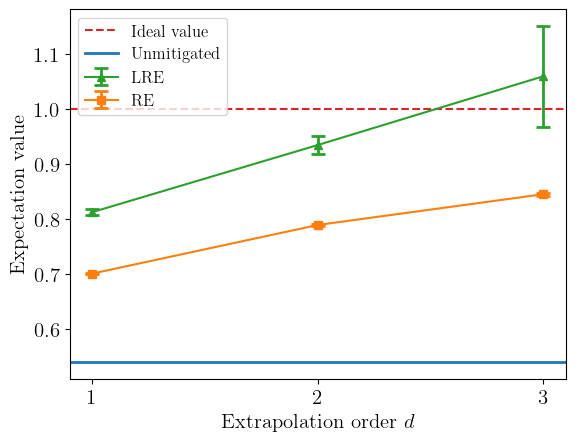

In [46]:
degrees = range(1, 4)
circuit = generate_ghz_circuit(4, "qiskit").compose(generate_ghz_circuit(4, "qiskit").inverse())

results = range_over_degree(
    circuit=circuit, degrees=degrees, optimize_shots=True, num_chunks=None, num_trials=10,
)


plot_experiment_expectation_values(
    results_list=results, 
    x_axis_key="degree",
    x_axis_label="Extrapolation order $d$", 
    save=True,
    is_log_scale=False,
    show_error_bars=True,
    is_unmit_static=True,    
    output_file_name=f"ghz_degree",
)

### Plot: Vary over the number of circuit chunks
<a id="vary_over_the_number_of_circuit_chunks"></a>

In [41]:
def range_over_chunk_sizes(
    circuit: qiskit.QuantumCircuit,
    num_chunks_list: list[int],
    optimize_shots: bool,
    shots: float = 10**6,
    backend: Backend = qiskit.Aer.get_backend("aer_simulator"),
    noise_model: NoiseModel = amplitude_damping_noise_model(),
    degree: float = 2,
    fold_multiplier: int = 1,
    num_trials: int = 1,
):
    return [
        {
            **run_experiment(
                circuit=circuit, 
                shots=shots,
                backend=backend, 
                noise_model=noise_model, 
                degree=degree,
                fold_multiplier=fold_multiplier,
                optimize_shots=optimize_shots,
                num_chunks=num_chunks,
                num_trials=num_trials,
            ),
            "circuit": circuit,
            "num_qubits": circuit.num_qubits,
            "shots": shots,
            "backend": backend,
            "noise_model": noise_model,
            "degree": degree,
            "fold_multiplier": fold_multiplier,
            "num_chunks": num_chunks,
            "num_trials": num_trials,
        }
        for num_chunks in num_chunks_list
    ]

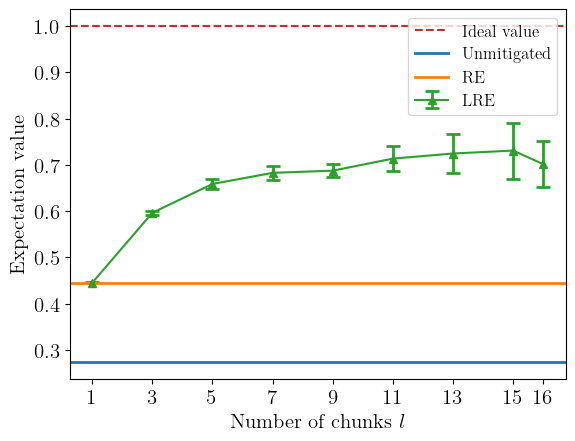

In [45]:
num_chunks_list = list(range(1, 16, 2)) + [16]
num_qubits = 8
circuit = generate_ghz_circuit(num_qubits, "qiskit").compose(generate_ghz_circuit(num_qubits, "qiskit").inverse())
results = range_over_chunk_sizes(
    circuit=circuit, optimize_shots=True, num_chunks_list=num_chunks_list, num_trials=10, shots=10**6
)

plot_experiment_expectation_values(
    results_list=results, 
    x_axis_key="num_chunks",
    x_axis_label="Number of chunks $l$", 
    save=True,
    is_log_scale=False,
    show_error_bars=True,
    is_zne_static=True,
    is_unmit_static=True,
    output_file_name=f"ghz_num_chunks",
)

### Plot: Benchmarking LRE with randomized circuits
<a id="benchmarking_lre_with_randomized_ciruits"></a>

In [54]:
def generate_random_circuit_data(num_examples, num_qubits, depth = 2, cnot_weight = 0.9):
    results = defaultdict(dict)
    for i in range(1, num_qubits):
        results["num_qubits"][i] = []

    for num_qubits in range(2, num_qubits):
        for example in range(num_examples):
            circuit = random_circuit(depth=depth, num_qubits=num_qubits, cnot_weight=cnot_weight)
            circuit = circuit.compose(circuit.inverse())

            result = run_experiment(
                circuit=circuit, 
                shots=10**6,
                backend=qiskit.Aer.get_backend("aer_simulator"),                 
                noise_model=amplitude_damping_noise_model(),          
                degree=2,
                fold_multiplier=1,
                optimize_shots=True,
                num_chunks=None
            )
            results["num_qubits"][num_qubits].append(result)
    with open(os.path.join("data", f"random_circuits.pickle"), "wb") as handle:    
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)  
        
    return results

In [38]:
num_qubits = 7
results = generate_random_circuit_data(num_examples=10, num_qubits=num_qubits)

                         
q_0: ──■────■────■────■──
     ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐
q_1: ┤ X ├┤ X ├┤ X ├┤ X ├
     └───┘└───┘└───┘└───┘
********************************************
Trial number 0
********************************************
Ideal value: 1.0

Executing circuit with shots = 1000000
Unmitigated expectation value: 0.512873
Unmitigated estimation error: 0.487127

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 3
Start running circuits.
Executing circuit with shots = 535714
Noise scaled value with scale factors (1,) is: 0.514162407553284
Executing circuit with shots = 357142
Noise scaled value with scale factors (3,) is: 0.13492952383085718
Executing circuit with shots = 107142
Noise scaled value with scale factors (5,) is: 0.03558828470627765
End running circuits.
ZNE expectation value: 0.8087382161386903
ZNE estimation error: 0.19126178386130965

Number of layers (w/o measurements): 4
Start computing

Noise scaled value with scale factors (1, 3, 3, 1) is: 0.26181570894253653
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 3, 1, 3) is: 0.26548792927575654
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 1, 5, 1) is: 0.2631244899809593
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 1, 3, 3) is: 0.26222373342400546
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 1, 1, 5) is: 0.25614289600145074
End running circuits.
Layerwise ZNE expectation value: 0.9224924708416237
Layerwise ZNE estimation error: 0.07750752915837633

Layerwise error-rate improvement over ZNE: 149.63%
                         
q_0: ──■────■────■────■──
     ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐
q_1: ┤ X ├┤ X ├┤ X ├┤ X ├
     └───┘└───┘└───┘└───┘
********************************************
Trial number 0
********************************************
Ideal value: 1.0

Executing circuit with shots = 1000000
Unmitiga

Noise scaled value with scale factors (1, 3, 3, 1) is: 0.2635838150289017
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 3, 1, 3) is: 0.2597075824549473
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 1, 5, 1) is: 0.2633965001360051
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 1, 3, 3) is: 0.26365181910914653
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 1, 1, 5) is: 0.269924743857104
End running circuits.
Layerwise ZNE expectation value: 0.9354635962541177
Layerwise ZNE estimation error: 0.06453640374588232

Layerwise error-rate improvement over ZNE: 198.08%
     ┌───┐          ┌───┐
q_0: ┤ Z ├──■────■──┤ Z ├
     ├───┤┌─┴─┐┌─┴─┐├───┤
q_1: ┤ X ├┤ X ├┤ X ├┤ X ├
     └───┘└───┘└───┘└───┘
********************************************
Trial number 0
********************************************
Ideal value: 1.0

Executing circuit with shots = 1000000
Unmitigated 

Noise scaled value with scale factors (1, 3, 3, 1) is: 0.26269976198571915
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 3, 1, 3) is: 0.2616116967018021
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 1, 5, 1) is: 0.26783933266841964
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 1, 3, 3) is: 0.26167970078204694
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 1, 1, 5) is: 0.26258046967086773
End running circuits.
Layerwise ZNE expectation value: 0.9242094635569671
Layerwise ZNE estimation error: 0.07579053644303291

Layerwise error-rate improvement over ZNE: 156.41%
                         
q_0: ──■────■────■────■──
     ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐
q_1: ┤ X ├┤ X ├┤ X ├┤ X ├
     └───┘└───┘└───┘└───┘
********************************************
Trial number 0
********************************************
Ideal value: 1.0

Executing circuit with shots = 1000000
Unmitiga

Noise scaled value with scale factors (1, 1, 5, 1) is: 0.3764620545833711
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 1, 3, 3) is: 0.3091465487929276
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 1, 1, 5) is: 0.2633058300843231
End running circuits.
Layerwise ZNE expectation value: 0.932309778080416
Layerwise ZNE estimation error: 0.06769022191958396

Layerwise error-rate improvement over ZNE: 129.03%
                           
q_0: ──■────■────■─────■───
     ┌─┴─┐┌─┴─┐┌─┴─┐ ┌─┴─┐ 
q_1: ┤ X ├┤ X ├┤ X ├─┤ X ├─
     ├───┤├───┤├───┤┌┴───┴┐
q_2: ┤ T ├┤ X ├┤ X ├┤ Tdg ├
     └───┘└───┘└───┘└─────┘
********************************************
Trial number 0
********************************************
Ideal value: 1.0

Executing circuit with shots = 1000000
Unmitigated expectation value: 0.454388
Unmitigated estimation error: 0.545612

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerw

Noise scaled value with scale factors (3, 3, 1, 1) is: 0.18762325739544372
Executing circuit with shots = 14705
Noise scaled value with scale factors (3, 1, 3, 1) is: 0.18932335940156408
Executing circuit with shots = 14705
Noise scaled value with scale factors (3, 1, 1, 3) is: 0.1934716082964978
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 5, 1, 1) is: 0.19226584459153143
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 3, 3, 1) is: 0.18109486569194153
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 3, 1, 3) is: 0.19143148588915335
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 1, 5, 1) is: 0.19054311360957477
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 1, 3, 3) is: 0.19007140428425706
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 1, 1, 5) is: 0.19126847402303018
End running circuits.
Layerwis

Noise scaled value with scale factors (1, 1, 1, 1) is: 0.45652672826336416
Executing circuit with shots = 117647
Noise scaled value with scale factors (3, 1, 1, 1) is: 0.30395165197582596
Executing circuit with shots = 117647
Noise scaled value with scale factors (1, 3, 1, 1) is: 0.31467865733932865
Executing circuit with shots = 117647
Noise scaled value with scale factors (1, 1, 3, 1) is: 0.31622565811282904
Executing circuit with shots = 117647
Noise scaled value with scale factors (1, 1, 1, 3) is: 0.30060265030132516
Executing circuit with shots = 22058
Noise scaled value with scale factors (5, 1, 1, 1) is: 0.19992746395865446
Executing circuit with shots = 14705
Noise scaled value with scale factors (3, 3, 1, 1) is: 0.21081264875892552
Executing circuit with shots = 14705
Noise scaled value with scale factors (3, 1, 3, 1) is: 0.2125807548452907
Executing circuit with shots = 14705
Noise scaled value with scale factors (3, 1, 1, 3) is: 0.20306018361101666
Executing circuit with sho

Unmitigated expectation value: 0.264012
Unmitigated estimation error: 0.735988

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 3
Start running circuits.
Executing circuit with shots = 535714
Noise scaled value with scale factors (1,) is: 0.2639468074382973
Executing circuit with shots = 357142
Noise scaled value with scale factors (3,) is: 0.018463244311786347
Executing circuit with shots = 107142
Noise scaled value with scale factors (5,) is: 0.0012880103040824327
End running circuits.
ZNE expectation value: 0.47230421242110554
ZNE estimation error: 0.5276957875788945

Number of layers (w/o measurements): 4
Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 15
Start running circuits.
Executing circuit with shots = 352941
Noise scaled value with scale factors (1, 1, 1, 1) is: 0.2625169645918156
Executing circuit with shots = 11764

Noise scaled value with scale factors (1, 3, 3, 1) is: 0.07256035362121727
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 3, 1, 3) is: 0.0633798027881673
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 1, 5, 1) is: 0.07226403119049778
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 1, 3, 3) is: 0.06746004760285618
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 1, 1, 5) is: 0.06732251337383262
End running circuits.
Layerwise ZNE expectation value: 0.7071253132068307
Layerwise ZNE estimation error: 0.2928746867931693

Layerwise error-rate improvement over ZNE: 80.03%
                                   
q_0: ──■─────────■────■─────────■──
       │       ┌─┴─┐┌─┴─┐       │  
q_1: ──┼────■──┤ X ├┤ X ├──■────┼──
     ┌─┴─┐  │  ├───┤├───┤  │  ┌─┴─┐
q_2: ┤ X ├──┼──┤ Y ├┤ Y ├──┼──┤ X ├
     └───┘┌─┴─┐├───┤├───┤┌─┴─┐└───┘
q_3: ─────┤ X ├┤ Z ├┤ Z ├┤ X ├─────
          └───

Noise scaled value with scale factors (1, 1, 1, 1) is: 0.3269554968110817
Executing circuit with shots = 117647
Noise scaled value with scale factors (3, 1, 1, 1) is: 0.1683935841967921
Executing circuit with shots = 117647
Noise scaled value with scale factors (1, 3, 1, 1) is: 0.21012860506430253
Executing circuit with shots = 117647
Noise scaled value with scale factors (1, 1, 3, 1) is: 0.20825010412505207
Executing circuit with shots = 117647
Noise scaled value with scale factors (1, 1, 1, 3) is: 0.16752658376329188
Executing circuit with shots = 22058
Noise scaled value with scale factors (5, 1, 1, 1) is: 0.0864992293045607
Executing circuit with shots = 14705
Noise scaled value with scale factors (3, 3, 1, 1) is: 0.1101666099965998
Executing circuit with shots = 14705
Noise scaled value with scale factors (3, 1, 3, 1) is: 0.10792247534852091
Executing circuit with shots = 14705
Noise scaled value with scale factors (3, 1, 1, 3) is: 0.08622917375042502
Executing circuit with shots 

Unmitigated expectation value: 0.263661
Unmitigated estimation error: 0.7363390000000001

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 3
Start running circuits.
Executing circuit with shots = 535714
Noise scaled value with scale factors (1,) is: 0.26204653975815456
Executing circuit with shots = 357142
Noise scaled value with scale factors (3,) is: 0.01823084375402501
Executing circuit with shots = 107142
Noise scaled value with scale factors (5,) is: 0.00129734371208303
End running circuits.
ZNE expectation value: 0.4690352112460398
ZNE estimation error: 0.5309647887539601

Number of layers (w/o measurements): 4
Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 15
Start running circuits.
Executing circuit with shots = 352941
Noise scaled value with scale factors (1, 1, 1, 1) is: 0.2628002980668157
Executing circuit with shots 

Unmitigated expectation value: 0.223949
Unmitigated estimation error: 0.776051

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 3
Start running circuits.
Executing circuit with shots = 535714
Noise scaled value with scale factors (1,) is: 0.22409718618516597
Executing circuit with shots = 357142
Noise scaled value with scale factors (3,) is: 0.011530427673026415
Executing circuit with shots = 107142
Noise scaled value with scale factors (5,) is: 0.0006533385600418136
End running circuits.
ZNE expectation value: 0.406014191465919
ZNE estimation error: 0.593985808534081

Number of layers (w/o measurements): 4
Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 15
Start running circuits.
Executing circuit with shots = 352941
Noise scaled value with scale factors (1, 1, 1, 1) is: 0.2227199446933057
Executing circuit with shots = 117647


Noise scaled value with scale factors (1, 1, 5, 1) is: 0.04959651827001541
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 1, 3, 3) is: 0.046446786807208436
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 1, 1, 5) is: 0.04887115785655998
End running circuits.
Layerwise ZNE expectation value: 0.6425903564458603
Layerwise ZNE estimation error: 0.35740964355413973

Layerwise error-rate improvement over ZNE: 65.97%
     ┌───┐                         ┌───┐     
q_0: ┤ X ├───────■──────────────■──┤ X ├─────
     └───┘       │              │  └───┘     
q_1: ──■─────────┼────■────■────┼─────────■──
       │         │  ┌─┴─┐┌─┴─┐  │         │  
q_2: ──┼────■────┼──┤ X ├┤ X ├──┼────■────┼──
       │  ┌─┴─┐┌─┴─┐└───┘└───┘┌─┴─┐┌─┴─┐  │  
q_3: ──┼──┤ X ├┤ X ├──────────┤ X ├┤ X ├──┼──
     ┌─┴─┐├───┤├───┤          └───┘└───┘┌─┴─┐
q_4: ┤ X ├┤ X ├┤ X ├────────────────────┤ X ├
     └───┘└───┘└───┘                    └───┘
*****************

Noise scaled value with scale factors (1,) is: 0.27512814673501157
Executing circuit with shots = 357142
Noise scaled value with scale factors (3,) is: 0.02138365132076317
Executing circuit with shots = 107142
Noise scaled value with scale factors (5,) is: 0.0015400123200985608
End running circuits.
ZNE expectation value: 0.48971321559722986
ZNE estimation error: 0.5102867844027701

Number of layers (w/o measurements): 4
Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 15
Start running circuits.
Executing circuit with shots = 352941
Noise scaled value with scale factors (1, 1, 1, 1) is: 0.27525847096256884
Executing circuit with shots = 117647
Noise scaled value with scale factors (3, 1, 1, 1) is: 0.13469106734553368
Executing circuit with shots = 117647
Noise scaled value with scale factors (1, 3, 1, 1) is: 0.1536375768187884
Executing circuit with shots = 117647
Noise scaled value with scale factors (1, 1,

End layerwise folding.
Number of folded circuits 3
Start running circuits.
Executing circuit with shots = 535714
Noise scaled value with scale factors (1,) is: 0.2460043978690122
Executing circuit with shots = 357142
Noise scaled value with scale factors (3,) is: 0.015050036120086688
Executing circuit with shots = 107142
Noise scaled value with scale factors (5,) is: 0.0010640085120680964
End running circuits.
ZNE expectation value: 0.44284470404631515
ZNE estimation error: 0.5571552959536848

Number of layers (w/o measurements): 4
Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 15
Start running circuits.
Executing circuit with shots = 352941
Noise scaled value with scale factors (1, 1, 1, 1) is: 0.2463867898600616
Executing circuit with shots = 117647
Noise scaled value with scale factors (3, 1, 1, 1) is: 0.12211106105553053
Executing circuit with shots = 117647
Noise scaled value with scale factors (1, 3,

Noise scaled value with scale factors (5, 1, 1, 1) is: 0.05607942696527337
Executing circuit with shots = 14705
Noise scaled value with scale factors (3, 3, 1, 1) is: 0.06256375382522951
Executing circuit with shots = 14705
Noise scaled value with scale factors (3, 1, 3, 1) is: 0.06045562733764026
Executing circuit with shots = 14705
Noise scaled value with scale factors (3, 1, 1, 3) is: 0.05120707242434546
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 5, 1, 1) is: 0.06346903617735063
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 3, 3, 1) is: 0.0671880312818769
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 3, 1, 3) is: 0.060863651819109146
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 1, 5, 1) is: 0.06655181793453623
Executing circuit with shots = 14705
Noise scaled value with scale factors (1, 1, 3, 3) is: 0.05542332539952397
Executing circuit with shots 

Unmitigated expectation value: 0.135561
Unmitigated estimation error: 0.864439

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 3
Start running circuits.
Executing circuit with shots = 535714
Noise scaled value with scale factors (1,) is: 0.1352251387867407
Executing circuit with shots = 357142
Noise scaled value with scale factors (3,) is: 0.002514406034574483
Executing circuit with shots = 107142
Noise scaled value with scale factors (5,) is: 4.666704000298669e-05
End running circuits.
ZNE expectation value: 0.2504216278219219
ZNE estimation error: 0.7495783721780781

Number of layers (w/o measurements): 4
Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 15
Start running circuits.
Executing circuit with shots = 352941
Noise scaled value with scale factors (1, 1, 1, 1) is: 0.13583290124978395
Executing circuit with shots = 11764

Noise scaled value with scale factors (3, 1, 1, 1) is: 0.05929602964801482
Executing circuit with shots = 117647
Noise scaled value with scale factors (1, 3, 1, 1) is: 0.06964053482026741
Executing circuit with shots = 117647
Noise scaled value with scale factors (1, 1, 3, 1) is: 0.06977653488826745
Executing circuit with shots = 117647
Noise scaled value with scale factors (1, 1, 1, 3) is: 0.05904102952051476
Executing circuit with shots = 22058
Noise scaled value with scale factors (5, 1, 1, 1) is: 0.02176081240366307
Executing circuit with shots = 14705
Noise scaled value with scale factors (3, 3, 1, 1) is: 0.025977558653519212
Executing circuit with shots = 14705
Noise scaled value with scale factors (3, 1, 3, 1) is: 0.026929615776946615
Executing circuit with shots = 14705
Noise scaled value with scale factors (3, 1, 1, 3) is: 0.02305338320299218
Executing circuit with shots = 22058
Noise scaled value with scale factors (1, 5, 1, 1) is: 0.029921117055036722
Executing circuit with 

Unmitigated expectation value: 0.135221
Unmitigated estimation error: 0.864779

Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 3
Start running circuits.
Executing circuit with shots = 535714
Noise scaled value with scale factors (1,) is: 0.1347678052094961
Executing circuit with shots = 357142
Noise scaled value with scale factors (3,) is: 0.002385605725453741
Executing circuit with shots = 107142
Noise scaled value with scale factors (5,) is: 5.600044800358403e-05
End running circuits.
ZNE expectation value: 0.24972862777898944
ZNE estimation error: 0.7502713722210106

Number of layers (w/o measurements): 4
Start computing eta coeffs.
End computing eta coeffs.
Start layerwise folding.
End layerwise folding.
Number of folded circuits 15
Start running circuits.
Executing circuit with shots = 352941
Noise scaled value with scale factors (1, 1, 1, 1) is: 0.13546173439753387
Executing circuit with shots = 1176

In [39]:
results

defaultdict(dict,
            {'num_qubits': {1: [],
              2: [defaultdict(dict,
                           {0: {'ideal_val': 1.0,
                             'unmit_val': 0.512873,
                             'zne_val': 0.8087382161386903,
                             'lre_val': 0.9275245718140631}}),
               defaultdict(dict,
                           {0: {'ideal_val': 1.0,
                             'unmit_val': 0.512916,
                             'zne_val': 0.8080242173193649,
                             'lre_val': 0.9360583305607962}}),
               defaultdict(dict,
                           {0: {'ideal_val': 1.0,
                             'unmit_val': 0.513233,
                             'zne_val': 0.806515711732407,
                             'lre_val': 0.9224924708416237}}),
               defaultdict(dict,
                           {0: {'ideal_val': 1.0,
                             'unmit_val': 0.513356,
                             'zne_va

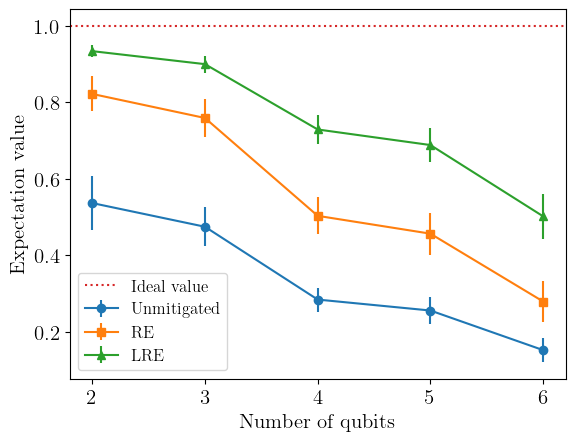

In [44]:
def calculate_stats(results):
    mean_vals = defaultdict(dict)
    std_vals = defaultdict(dict)
    
    for qubit_count, trials in results["num_qubits"].items():
        if trials:  # Check if there are any trials for the qubit count
            for val_type in ["ideal_val", "unmit_val", "zne_val", "lre_val"]:
                values = [trial[0][val_type] for trial in trials]
                mean_vals[qubit_count][val_type] = np.mean(values)
                std_vals[qubit_count][val_type] = np.std(values)
    
    return mean_vals, std_vals

def plot_results(mean_vals, std_vals):
    qubit_counts = sorted(mean_vals.keys())
    
    # Prepare plot markers for different val_types
    markers = {"unmit_val": "o", "zne_val": "s", "lre_val": "^"}  # Markers for each type
    colors = {"unmit_val": "tab:blue", "zne_val": "tab:orange", "lre_val": "tab:green"}  # Colors for each type

    # Plot the ideal value as a dotted line in 'tab:red'
    plt.axhline(y=1.0, color="tab:red", linestyle=":", label="Ideal value")

    for val_type, marker in markers.items():
        means = [mean_vals[qubit_count][val_type] for qubit_count in qubit_counts]
        stds = [std_vals[qubit_count][val_type] for qubit_count in qubit_counts]
        
        # Adjust labels
        if val_type == "zne_val":
            label = "RE"
        elif val_type == "lre_val":
            label = "LRE"
        elif val_type == "unmit_val":
            label = "Unmitigated"
        else:
            label = val_type.title().replace("_", " ")

        plt.errorbar(qubit_counts, means, yerr=stds, label=label, fmt=marker + "-", color=colors[val_type])

    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel("Number of qubits")
    plt.ylabel("Expectation value")
    plt.legend()
    plt.savefig(os.path.join("plots", f"random_circuits.pdf"))     
    plt.show()

# Assuming 'results' is your data structured as mentioned
mean_vals, std_vals = calculate_stats(results)
plot_results(mean_vals, std_vals)

## Miscellaneous tools
<a id="miscellaneous_tools"></a>

## $\LaTeX$ tools

These functions are helpful for converting the data obtained via the plotting/experiment section into $\LaTeX$-formatted tables

In [44]:
def data_to_latex_table(file_path: str, param_key_to_vary: str) -> str:
    """Helper function that converts saved pickle data files to LaTeX tables."""
    with open(file_path, "rb") as file:
        data = pickle.load(file)
    
    latex_table = """
    \\begin{table}[h!]
        \\centering
        \\begin{tabular}{c|c|c|c|c}            
    """
    latex_table += f"\t {param_key_to_vary} & Unmitigated & RE & LRE & Improvement \\\ \\hline \n"
    # Populate table with data.
    for exp in data:
        total_zne_error = 0
        total_lre_error = 0
        total_unmit_error = 0

        for trial in range(exp["num_trials"]):
            vary_key = exp[param_key_to_vary]                    
            ideal_val = exp[trial]["ideal_val"]
            unmit_val = exp[trial]["unmit_val"]
            zne_val = exp[trial]["zne_val"]
            lre_val = exp[trial]["lre_val"]

            zne_error = abs(ideal_val - zne_val)
            lre_error = abs(ideal_val - lre_val)
            unmit_error = abs(ideal_val - unmit_val)

            total_zne_error += zne_error
            total_lre_error += lre_error
            total_unmit_error += unmit_error

        avg_zne_error = total_zne_error / exp["num_trials"]
        avg_lre_error = total_lre_error / exp["num_trials"]
        avg_unmit_error = total_unmit_error / exp["num_trials"]
        avg_perc_improve = ((avg_zne_error - avg_lre_error) / avg_lre_error) * 100
        
        latex_table += f"\t {vary_key} & {avg_unmit_error:.4f} & {avg_zne_error:.4f} & {avg_lre_error:.4f} & {avg_perc_improve:.2f}\\% \\\ \n"
    latex_table += """
        \\end{tabular}
    \\end{table}
    """
       
    return latex_table

The table of mean absolute estimation errors for each data point of the GHZ-like circuit for ranging over the number of qubits (that can also be found in our paper) can be obtained here.

In [45]:
file_path = os.path.join("data", "ghz_num_qubits.pickle")
print(data_to_latex_table(file_path, "num_qubits"))


    \begin{table}[h!]
        \centering
        \begin{tabular}{c|c|c|c|c}            
    	 num_qubits & Unmitigated & RE & LRE & Improvement \\ \hline 
	 2 & 0.2078 & 0.0306 & 0.0174 & 75.41\% \\ 
	 3 & 0.3483 & 0.1107 & 0.0390 & 183.75\% \\ 
	 4 & 0.4599 & 0.2110 & 0.0662 & 218.79\% \\ 
	 5 & 0.5495 & 0.3121 & 0.0906 & 244.34\% \\ 
	 6 & 0.6206 & 0.4058 & 0.1640 & 147.40\% \\ 
	 7 & 0.6789 & 0.4856 & 0.2130 & 127.98\% \\ 
	 8 & 0.7261 & 0.5546 & 0.2607 & 112.76\% \\ 

        \end{tabular}
    \end{table}
    


## Plotting from loaded data

The following code shows how to generate a plot from previously saved data.

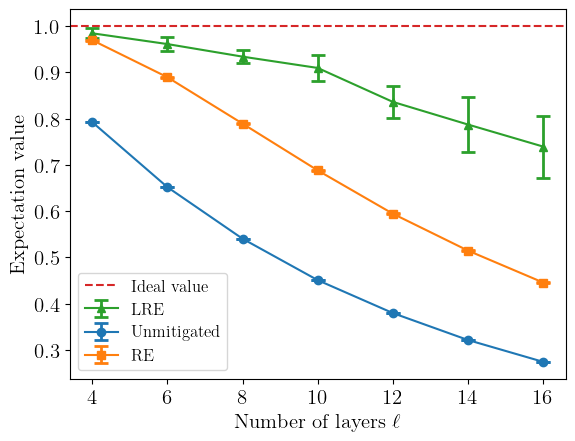

In [34]:
data_file_name = "ghz_num_qubits.pickle"
output_file_name = "ghz_num_qubits"

file = open(os.path.join("data", data_file_name), "rb")
results = pickle.load(file)

num_qubits = range(2, 9)
plot_experiment_expectation_values(
    results_list=results, 
    x_axis_key="num_qubits",
    x_axis_label="Number of layers $\ell$",
    # Num layers = 2 * num qubits. the relevant parameter of LRE is “l” not “n”. E.g., 
    # error bars increase because “l” increases, not because “n” increases.
    x_ticks_labels = [x * 2 for x in num_qubits],
    save=True,
    show_error_bars=True,
    is_log_scale=False,
    output_file_name=f"ghz_num_qubits",
)